<a href="https://colab.research.google.com/github/146790g/Mode-Of-Action-Data/blob/master/MOA_MLP_1_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mode of Action

##Mechanisms of Action (MoA) Prediction
##Can you improve the algorithm that classifies drugs based on their biological activity?

#（その１： Data Processing）



In [ ]:
%tensorflow_version 2.x

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls -lh '/content/gdrive/My Drive/Colab Notebooks/MOA/data'

total 539M
-rw------- 1 root root 3.2M Sep  2 06:04 sample_submission.csv
-rw------- 1 root root  25M Sep  2 06:04 test_features.csv
-rw------- 1 root root 150M Sep  2 06:04 train_features.csv
-rw------- 1 root root  19M Sep  2 06:04 train_targets_nonscored.csv
-rw------- 1 root root 9.7M Sep  2 06:04 train_targets_scored.csv
-rw------- 1 root root  32M Nov  3 08:01 X_fp_test
-rw------- 1 root root 190M Nov  3 08:01 X_fp_train
-rw------- 1 root root  38M Nov  3 08:01 y
-rw------- 1 root root  74M Nov  3 08:01 y0


# Module Load

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Adding iterative-stratification 
# Select add data from the right menu and search for iterative-stratification, then add it to your kernel.
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


from time import time
import datetime
import gc

import numpy as np
import pandas as pd 

# ML tools 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf 
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.metrics import log_loss
from tensorflow_addons.layers import WeightNormalization
# Setting random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set(font_scale=1.2)

# Data Inspection

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/gdrive/My Drive/Colab Notebooks/MOA/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



data_dir = '/content/gdrive/My Drive/Colab Notebooks/MOA/data'

/content/gdrive/My Drive/Colab Notebooks/MOA/data/test_features.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/sample_submission.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/train_features.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/train_targets_scored.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/train_targets_nonscored.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/X_fp_train
/content/gdrive/My Drive/Colab Notebooks/MOA/data/X_fp_test
/content/gdrive/My Drive/Colab Notebooks/MOA/data/y
/content/gdrive/My Drive/Colab Notebooks/MOA/data/y0


In [ ]:
df_train = pd.read_csv(os.path.join(data_dir,'train_features.csv'))
display(df_train.head(3))
print('train data size', df_train.shape)

df_target_ns = pd.read_csv(os.path.join(data_dir,'train_targets_nonscored.csv'))
display(df_target_ns.head(3))
print('train target nonscored size', df_target_ns.shape)


df_target_s = pd.read_csv(os.path.join(data_dir,'train_targets_scored.csv'))
display(df_target_s.head(3))
print('train target scored size', df_target_s.shape)


df_test = pd.read_csv(os.path.join(data_dir,'test_features.csv'))
display(df_test.head(3))
print('test data size', df_test.shape)

df_sample = pd.read_csv(os.path.join(data_dir,'sample_submission.csv'))
display(df_sample.head(3))
print('sample submission size', df_sample.shape)

print(type(df_target_s))



,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


train data size (23814, 876)


,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,aldose_reductase_inhibitor,alpha_mannosidase_inhibitor,ampk_inhibitor,androgen_biosynthesis_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antihypertensive,antimetabolite,antipruritic,antirheumatic_drug,antiseptic,antispasmodic,antithyroid_agent,antitussive,anxiolytic,ap_inhibitor,apolipoprotein_expression_enhancer,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,aspartic_protease_inhibitor,atherogenesis_inhibitor,atherosclerosis_formation_inhibitor,atp-sensitive_potassium_channel_agonist,atp-sensitive_potassium_channel_inhibitor,atp_channel_activator,atp_channel_blocker,...,thromboxane_synthase_inhibitor,thyroid_hormone_inhibitor,thyroid_hormone_stimulant,thyrotropin_releasing_hormone_receptor_agonist,tie_inhibitor,tissue_transglutaminase_inhibitor,topical_anesthetic,topical_sunscreen_agent,trace_amine_associated_receptor_agonist,trace_amine_associated_receptor_antagonist,trail_modulator,transient_receptor_potential_channel_agonist,triacylglycerol_lipase_inhibitor,tricyclic_antidepressant,tryptophan_hydroxylase_inhibitor,tyrosinase_inhibitor,tyrosine_hydroxylase_inhibitor,tyrosine_phosphatase_inhibitor,ubiquitin-conjugating_enzyme_inhibitor,ubiquitin_ligase_inhibitor,urease_inhibitor,uric_acid_diuretic,uricase_inhibitor,uricosuric,urotensin_receptor_agonist,urotensin_receptor_antagonist,vasoconstrictor,vasodilator,vasopressin_receptor_agonist,vasopressin_receptor_antagonist,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


train target nonscored size (23814, 403)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


train target scored size (23814, 207)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.214,0.2221,-0.3260,1.9390,-0.2305,-0.3670,1.304,1.4610,0.0043,0.6816,-0.2304,-0.0635,-0.2030,-0.6821,-0.6242,0.1297,-0.0338,0.3372,0.2254,0.4795,0.7642,0.6638,-0.2480,-0.1183,-0.4847,-0.0179,-0.8204,-0.5296,-1.5070,-0.0144,...,-0.1353,0.0494,0.8939,0.227,0.2876,-0.3065,0.6519,-0.8156,-1.4960,0.3796,0.0877,-1.0230,-0.0206,-0.4149,-0.6258,-0.2688,0.4403,-0.4900,0.2910,0.0473,-0.0914,0.3087,-0.0612,-0.9128,-0.9399,0.0173,0.0519,-0.0035,-0.5184,-0.3485,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.882,0.4022,-0.3528,0.1271,0.9303,0.3173,-1.012,-0.3213,0.0607,-0.5389,-0.8030,-1.0600,-0.0978,-0.8156,-0.6514,0.6812,0.5246,0.0000,0.5030,-0.1500,-0.1433,2.0910,-0.6556,-0.6012,-0.4104,-0.0580,-0.3608,0.2197,-0.7101,1.3430,...,-0.7458,0.0458,-0.3644,-1.818,-0.0358,-0.7925,-0.2693,-0.0938,-0.1833,-0.7402,-1.4090,0.1987,0.0460,-1.3520,-0.3445,-0.0909,-0.6337,-0.5788,-0.7885,0.0996,-1.9480,-1.2720,-0.7223,-0.5838,-1.3620,-0.7671,0.4881,0.5913,-0.4333,0.1234,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.339,-0.3206,0.6944,0.5837,-0.0553,-0.6222,2.543,-0.7857,0.8163,-0.0495,0.1806,1.0290,-0.5204,-1.1070,0.7365,-0.3835,-0.5771,0.0523,-0.2690,0.1674,0.6010,-0.6660,0.0276,0.0924,0.2785,-0.3943,-0.4602,-0.0673,-1.3420,0.3127,...,0.4369,-1.4960,1.2390,-1.222,0.6624,-0.7336,-0.5248,0.0727,0.1455,0.5364,-0.0823,0.5734,0.4876,0.7088,1.0750,0.4689,1.0870,-0.5036,-0.3451,0.5087,1.1100,0.7886,0.2093,-0.4617,1.4870,0.1985,1.1750,-0.5693,0.5062,-0.1925,-0.2261,0.3370,-1.384,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942


test data size (3982, 876)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


sample submission size (3982, 207)
<class 'pandas.core.frame.DataFrame'>


## train_features : df_train

In [ ]:
train_copy= df_train.copy()
print(type(train_copy))
train_copy['target_71'] = df_target_s.iloc[:,72] 
print(train_copy['target_71'])
print(df_target_s.columns[72])

<class 'pandas.core.frame.DataFrame'>
0        0
1        0
2        0
3        0
4        0
        ..
23809    0
23810    0
23811    0
23812    0
23813    0
Name: target_71, Length: 23814, dtype: int64
cyclooxygenase_inhibitor


## train_targets_nonscored : df_target_ns

In [ ]:
df_target_ns_copy= df_target_ns.copy()
print(type(df_target_ns_copy))
print(df_target_ns_copy.shape)

<class 'pandas.core.frame.DataFrame'>
(23814, 403)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

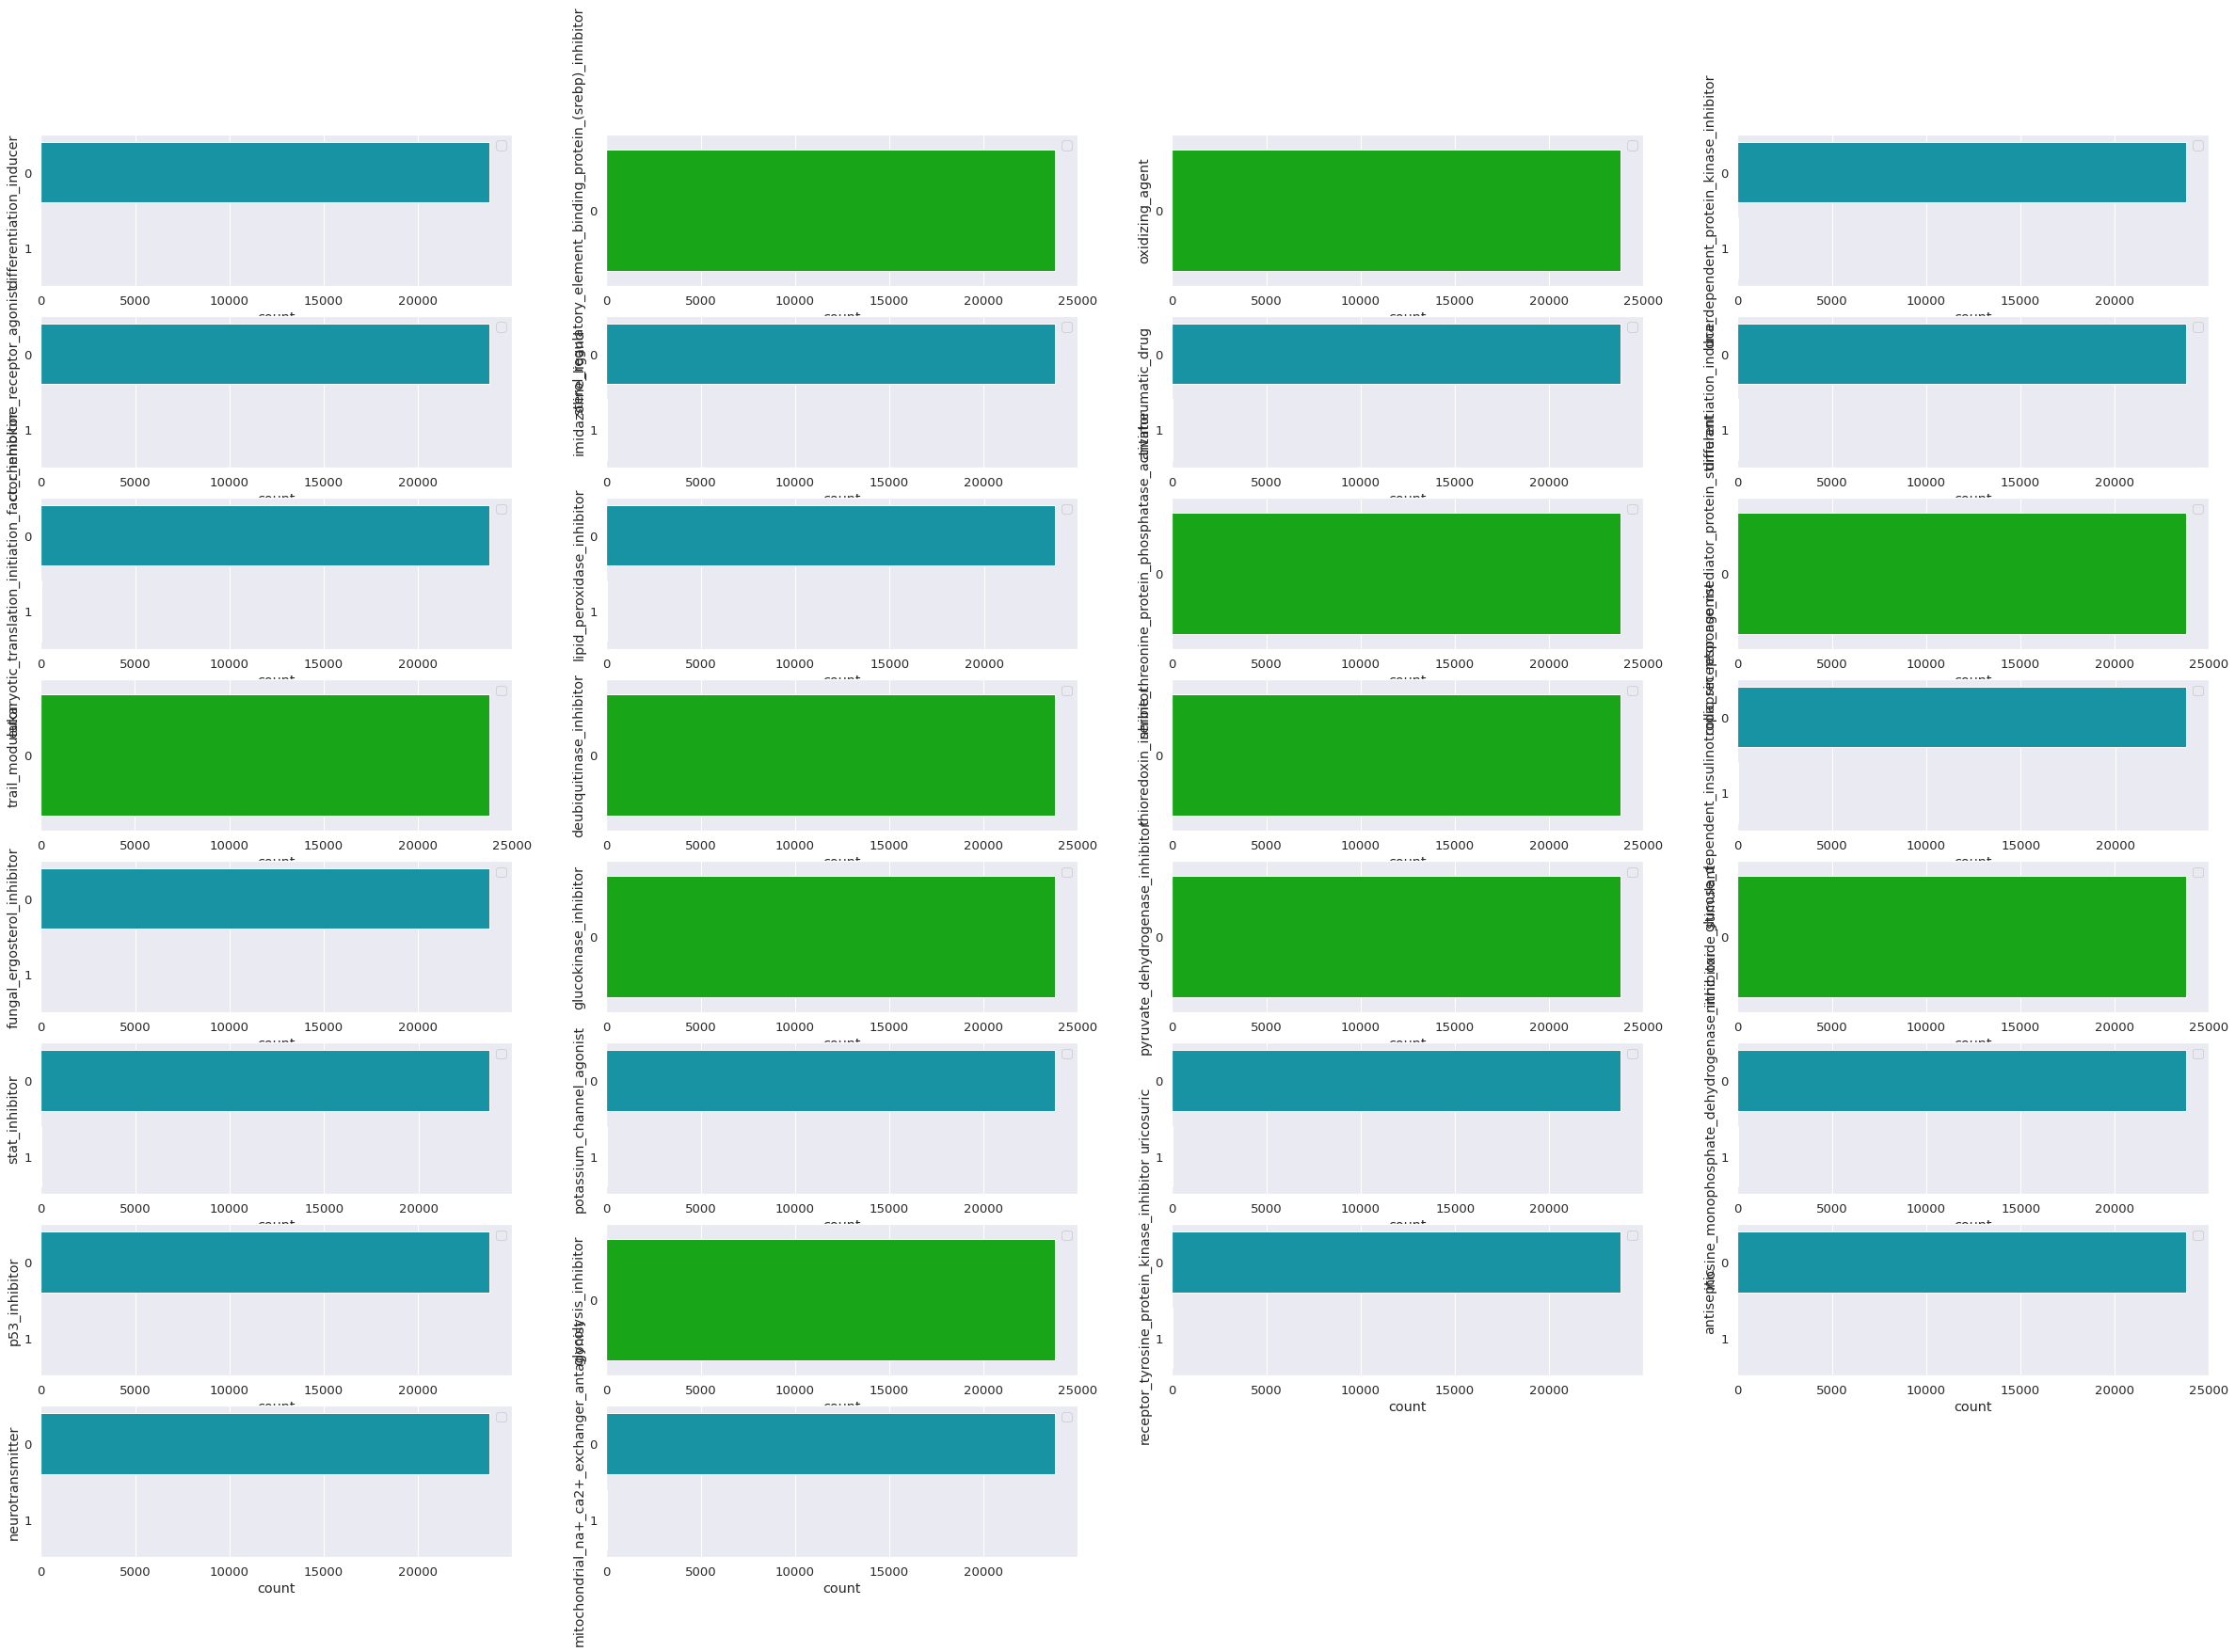

In [ ]:
df_target_ns_copy.drop('sig_id', axis=1, inplace=True)
n_row = 30
n_col = 4 
n_sub = 1   
fig = plt.figure(figsize=(20,50))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)

for i in np.random.choice(np.arange(0,df_target_ns_copy.shape[1],1),n_row):
    plt.subplot(n_row, n_col, n_sub)
    sns.countplot(y=df_target_ns_copy.iloc[:, i],palette='nipy_spectral',orient='h')
    
    plt.legend()                    
    n_sub+=1
plt.show()

In [ ]:
df_target_ns_copy.sum()

abc_transporter_expression_enhancer      6
abl_inhibitor                           24
ace_inhibitor                           91
acetylcholine_release_enhancer           6
adenosine_deaminase_inhibitor            0
                                        ..
voltage-gated_sodium_channel_blocker    18
wdr5_mll_interaction_inhibitor           6
wnt_agonist                              0
xanthine_oxidase_inhibitor              24
xiap_inhibitor                          24
Length: 402, dtype: int64

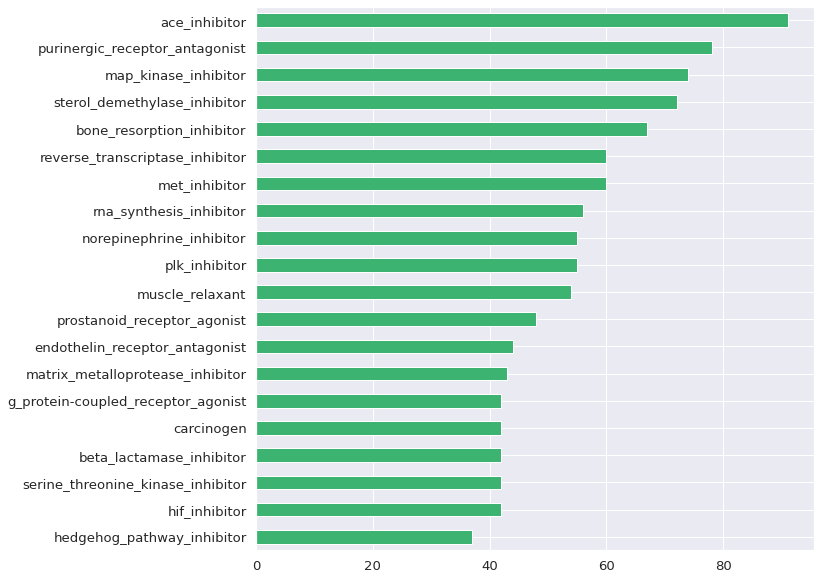

In [ ]:
plt.figure(figsize=(10,10))
df_target_ns_copy.sum().sort_values()[-20:].plot(kind='barh',color='mediumseagreen')
plt.show()

## train_targets_scored : df_target_s

In [ ]:
target_s_copy=df_target_s.copy()
print(type(target_s_copy))
print(target_s_copy.shape)

<class 'pandas.core.frame.DataFrame'>
(23814, 207)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

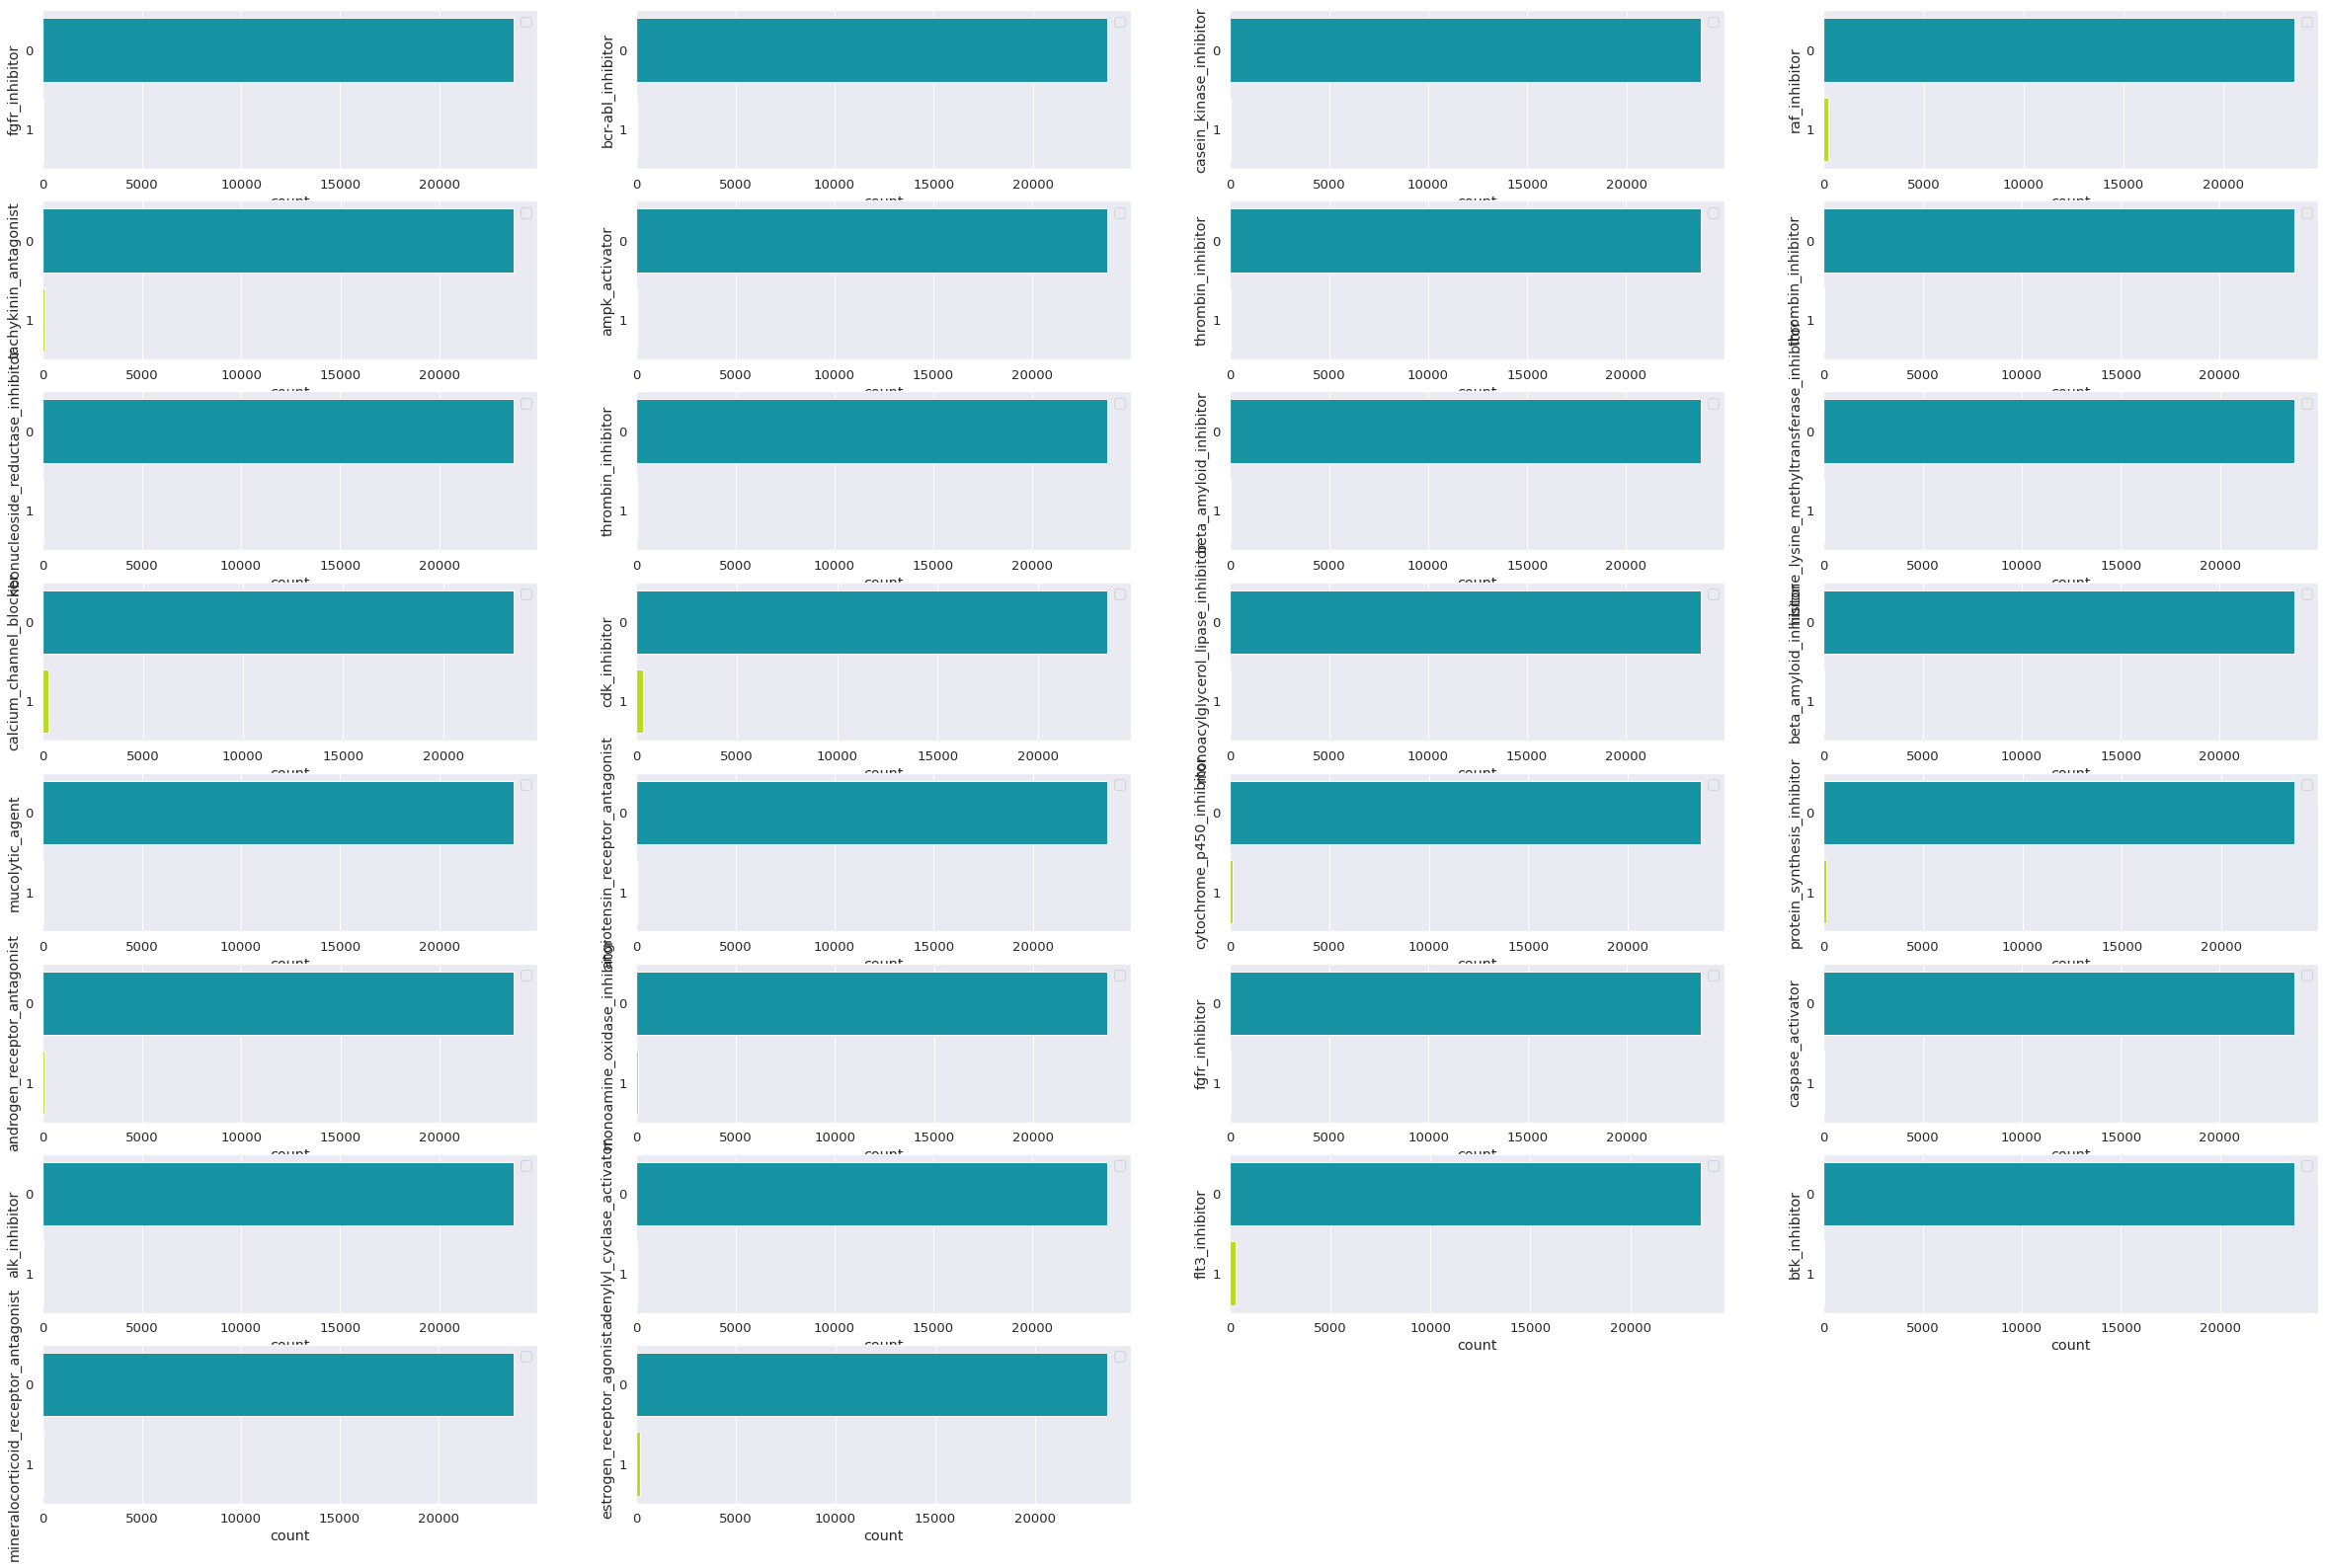

In [ ]:
target_s_copy.drop('sig_id', axis=1, inplace=True)
n_row = 30
n_col = 4 
n_sub = 1   
fig = plt.figure(figsize=(20,50))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)

for i in np.random.choice(np.arange(0,target_s_copy.shape[1],1),n_row):
    plt.subplot(n_row, n_col, n_sub)
    sns.countplot(y=target_s_copy.iloc[:, i],palette='nipy_spectral',orient='h')
    
    plt.legend()                    
    n_sub+=1
plt.show()

In [ ]:
target_s_copy.sum()

5-alpha_reductase_inhibitor               17
11-beta-hsd1_inhibitor                    18
acat_inhibitor                            24
acetylcholine_receptor_agonist           190
acetylcholine_receptor_antagonist        301
                                        ... 
ubiquitin_specific_protease_inhibitor      6
vegfr_inhibitor                          170
vitamin_b                                 26
vitamin_d_receptor_agonist                39
wnt_inhibitor                             30
Length: 206, dtype: int64

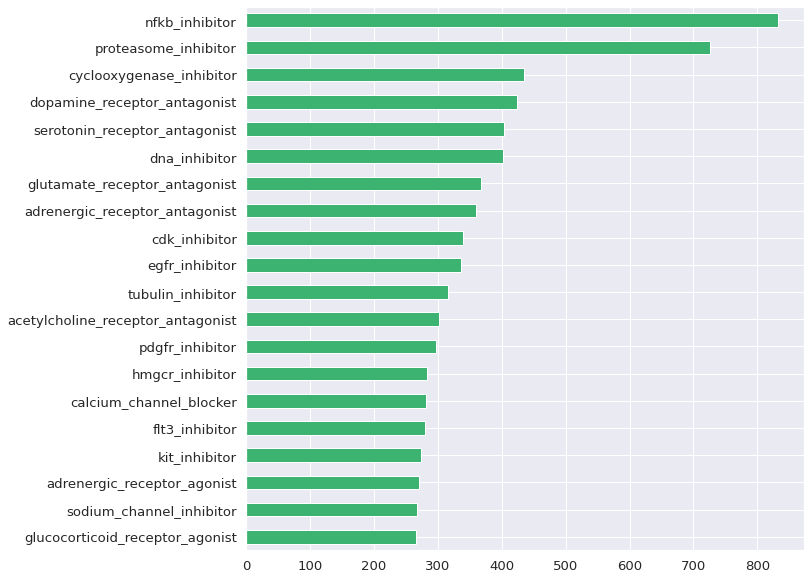

In [ ]:
plt.figure(figsize=(10,10))
target_s_copy.sum().sort_values()[-20:].plot(kind='barh',color='mediumseagreen')
plt.show()

# Data Preprocessing

# Preprocessing for 772 gene expression features

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(n_quantiles=100,random_state=42, output_distribution="normal")

def preprocess(df):
    df['cp_time'] = df['cp_time'].map({24:1, 48:2, 72:3})
    df['cp_dose'] = df['cp_dose'].map({'D1':0, 'D2':1})
    df['cp_type'] = df['cp_type'].map({'trt_cp':0, 'ctl_vehicle':1})
    g_features = [cols for cols in df.columns if cols.startswith('g-')]
    c_features = [cols for cols in df.columns if cols.startswith('c-')]
    for col in (g_features + c_features):
        vec_len = len(df[col].values)
        raw_vec = df[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)
        df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    return df

df_train_1 = preprocess(df_train)
df_test_1 = preprocess(df_test)

display(df_train_1.head(3))
print('Train data size', df_train_1.shape)

display(df_train_1.tail(3))


display(df_test_1.head(3))
print('Test data size', df_test_1.shape)

display(df_test_1.tail(3))


y_1 = df_target_s.drop('sig_id', axis=1)
display(y.head(3))
print('target size', y_1.shape)
y0_1 =  df_target_ns.drop('sig_id', axis=1)
print('non target size', y0_1.shape)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,0,1,0,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,...,0.719016,0.778481,0.536757,1.327282,0.157853,0.186734,0.230732,1.940627,-0.719241,1.851499,-0.062590,1.114905,0.883171,1.403209,0.224713,0.076150,0.560326,1.309312,0.946857,-0.801600,1.908884,0.940878,-0.542073,0.191524,2.194069,0.248358,0.780708,-0.145965,-1.125801,1.049904,0.410974,0.364819,1.291804,0.835350,-0.240101,1.021706,-0.499652,0.317989,0.545662,0.641339
1,id_000779bfc,0,3,0,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,...,0.609301,0.104950,0.569065,1.109095,0.435015,0.632035,-0.374352,-0.388334,-0.762890,0.424436,-0.092101,0.386876,0.671709,0.853389,0.170340,1.178457,0.759411,-0.406442,-0.113337,0.625945,-0.355584,1.172363,0.868525,0.500542,0.214436,0.645295,1.394635,1.211742,-0.528146,0.507482,-0.520372,1.127405,0.716111,0.054620,0.412012,0.744215,0.210242,0.179684,0.919161,1.165833
2,id_000a6266a,0,2,0,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,...,-0.635542,-0.873922,-0.052395,0.276048,0.006609,-1.289996,-0.591502,0.171967,-0.633092,-0.069898,0.240677,-0.545393,0.750383,0.194436,0.352697,1.526166,-0.084895,-0.141983,0.152105,0.089034,-1.015340,-0.852661,-0.151391,-0.742431,0.436651,0.160259,0.137482,-0.415975,0.456803,-0.078962,-0.828896,-0.740965,0.953239,0.053633,-1.213056,-0.394118,-0.758652,-0.277635,-1.123088,1.089235


Train data size (23814, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
23811,id_fffc1c3f4,1,2,1,0.525149,0.631225,0.288173,-1.139968,0.769550,0.001014,-0.342051,0.301949,-0.057905,0.413428,-0.292835,0.068733,0.148097,-0.070861,0.247392,-0.362196,-0.202659,-0.555928,0.806106,-0.732525,0.209962,-0.287611,0.382218,-1.075680,0.631506,1.014263,-0.514506,-1.747011,0.705345,1.533285,-0.333329,-2.228753,-0.483052,-0.039637,-0.388145,-0.319721,...,1.032660,1.117616,1.101935,0.717017,-0.260264,0.402851,0.710985,0.603879,0.827407,2.196020,-0.719853,0.907269,0.517834,1.447897,-0.189856,-0.237617,-0.038419,-0.027433,0.866659,0.726647,0.163047,0.303887,1.029174,0.108186,0.915315,0.314662,0.866803,0.396143,0.068063,1.979414,0.802650,0.544226,1.168630,0.416970,0.580636,0.996878,0.314929,1.167104,1.020593,0.584393
23812,id_fffcb9e7c,0,1,0,0.816407,0.417618,0.431631,0.300617,1.070346,-0.024189,0.048942,0.099569,0.530544,-1.192202,0.734399,0.158032,1.701151,0.245542,0.783855,-2.230810,-0.003841,0.837035,0.434615,1.470730,-0.960929,1.379173,0.547816,2.454712,0.629175,0.982162,0.308853,-0.501952,1.232470,-1.807909,-0.341514,-0.442511,1.157098,-0.066272,-0.120785,1.618710,...,0.502048,-0.727690,0.738976,1.464467,0.665657,0.029824,0.601503,0.688787,-0.128317,0.662172,0.603568,0.213470,-0.681428,0.066483,1.288157,1.628607,-0.066502,-0.509888,1.150393,-0.758817,-0.183352,1.093103,1.174303,-0.081298,1.353819,0.325318,1.446929,1.617618,0.642609,0.814420,-0.132408,0.621426,-0.250549,0.228001,2.198247,1.104170,0.239943,1.077975,-0.701998,0.133967
23813,id_ffffdd77b,0,3,0,-1.243096,1.567730,-0.269573,1.083636,-0.511235,-2.099634,-1.622462,1.427119,2.265893,1.254935,2.079216,1.285291,1.887771,1.622566,-0.750758,1.187451,-1.378809,0.031455,-1.770325,-0.070341,-0.254503,-0.962528,-1.867759,-1.305622,-1.207604,-0.717776,-1.252084,-0.433663,0.257184,-0.579283,0.523161,-0.315034,-1.002237,-0.303185,-1.562002,-0.815612,...,-1.748691,-1.552905,-1.495927,-1.517728,-1.353798,-1.462069,-1.502084,-1.579996,-1.236172,-1.262187,-1.562191,-1.273803,-1.131847,-1.443369,0.108899,-1.453895,-1.521270,-1.402970,-1.534445,-1.701102,-1.587985,-1.455862,-1.446589,-1.470949,-1.454648,-1.422717,-1.656959,-0.186271,-1.652439,-1.623799,-1.571641,-1.400249,-1.737165,-1.639028,-1.747229,-1.289910,-1.571384,-0.581703,-1.298407,-1.847225


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,0,1,0,-0.755294,0.214796,-0.774511,0.705349,1.564580,-0.194968,-0.276944,0.363393,-0.444533,1.805324,-0.371021,-0.479669,1.294179,1.375143,0.051658,1.172079,-0.440924,-0.062191,-0.515950,-0.897857,-0.789403,0.331908,0.013708,0.731217,0.280174,0.726955,1.007077,0.758206,-0.463151,-0.205948,-0.729595,-0.068265,-0.926625,-0.757403,-1.410264,-0.018377,...,-0.198851,0.097584,1.364199,0.295738,0.397828,-0.429947,0.908127,-0.943323,-1.432914,0.561826,0.085382,-1.132801,-0.033252,-0.492298,-1.032975,-0.390962,0.571419,-0.646490,0.413347,0.008858,-0.137114,0.447321,-0.129989,-1.030313,-1.073490,0.026809,0.024562,-0.021795,-0.667219,-0.398334,0.116890,1.194732,-0.195260,-0.298039,-0.301677,-0.128405,-0.036089,-0.094841,0.153376,-0.920303
1,id_001897cda,0,3,0,-0.186773,0.374643,1.176402,-0.652299,-0.546638,-0.403447,-2.325903,0.645634,-0.485088,-0.048936,1.210023,0.419276,-1.275817,-0.425276,0.132044,-0.890770,-1.146702,-1.251700,-0.274084,-1.058294,-0.821554,1.029957,0.843801,0.088734,0.644651,-0.194701,-0.240824,1.799069,-1.067548,-0.836341,-0.634064,-0.140889,-0.423926,0.252623,-0.830175,1.399657,...,-0.868834,0.092470,-0.491143,-1.338950,-0.046113,-0.891663,-0.377606,-0.156344,-0.226732,-0.901261,-1.259115,0.300108,0.065126,-1.219456,-0.616402,-0.162918,-0.788433,-0.749537,-0.921389,0.075357,-1.437453,-1.254469,-0.861142,-0.740949,-1.316315,-0.915945,0.745559,0.840110,-0.565178,0.207971,-0.183415,-0.269845,-1.059129,-1.317859,-0.466468,-0.653500,-0.015480,-0.621168,-1.191952,-0.880456
2,id_002429b5b,1,1,0,0.351229,-0.155308,-0.613250,0.255053,-1.762152,0.333321,-0.434423,-0.484560,0.857189,0.514641,-0.132592,-0.834668,1.793695,-1.108673,1.197317,-0.086980,0.054445,1.397045,-1.129795,-1.353153,1.041231,-0.465987,-0.838953,0.284006,-0.377608,0.284396,0.769001,-0.964506,0.009738,0.077140,0.418757,-0.766888,-0.551620,-0.150097,-1.309084,0.404371,...,0.607276,-1.429268,1.916949,-1.135881,0.999449,-0.845084,-0.686448,0.066024,0.218743,0.779444,-0.150719,0.869971,0.723740,0.971419,1.352093,0.638580,1.507330,-0.666720,-0.443788,0.696583,1.710023,1.152024,0.252428,-0.605626,2.125087,0.281960,1.824982,-0.759893,0.730202,-0.204462,-0.328362,0.463214,-1.233935,1.310102,-1.429491,-1.093671,1.239167,1.577578,0.681627,-0.241098


Test data size (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
3979,id_ffb710450,0,3,0,-0.509991,-0.176776,0.253602,-1.024748,0.090795,0.651001,-0.010759,1.199610,0.058394,1.388999,0.590700,-0.564485,-0.228655,-0.365704,0.669317,-1.282557,-0.375546,1.336705,0.984368,-1.211171,-1.366442,-0.157726,-0.260709,0.731217,1.065548,-0.472339,0.590759,-0.318272,-0.118965,-0.389405,-0.601080,-1.408352,-0.370222,-0.479179,0.463364,0.805624,...,-0.024333,0.724808,0.916948,1.952331,-0.216737,0.753981,1.234323,0.714077,-0.559523,-0.250067,0.389406,0.396574,0.443960,0.648756,1.800695,1.902731,-0.557403,-0.305446,0.472335,-0.041501,0.981436,0.328284,0.799013,0.936055,0.844673,1.170942,0.793599,-0.403137,-0.389703,0.815213,0.616963,1.381257,-0.250516,0.559311,1.388491,0.691381,0.001143,0.840178,-0.553927,-0.185527
3980,id_ffbb869f2,0,2,1,-1.627922,-2.062092,-0.623309,1.373145,-1.686176,-0.260062,-0.461480,-1.343508,1.211694,0.612481,1.860223,0.795062,1.263520,1.344597,1.459726,0.833071,-0.360588,0.764124,0.041887,-0.107310,1.316625,-1.847136,0.392093,-1.044310,-1.181571,0.963086,1.344427,0.544591,-0.356151,0.606034,0.969789,0.125066,-1.789678,0.836346,0.026690,-0.936571,...,0.191350,-0.242546,0.528777,1.452712,-0.540192,-0.210580,0.114322,0.891018,0.400861,1.174980,-0.540481,0.782747,-0.403557,-0.063321,0.313933,0.161172,1.003654,0.374450,0.309220,0.242833,-0.561248,0.091689,1.184097,0.540882,0.210887,-0.237829,0.759048,-1.005629,-0.998774,0.200393,0.407732,-0.592693,-0.924480,1.164802,0.429694,0.206305,-0.397434,0.717984,1.109499,-0.050339
3981,id_ffd5800b6,0,3,0,-0.705098,0.473736,0.314137,-0.011752,-0.055045,1.106466,-1.171063,0.626582,-0.064618,0.229781,0.253727,0.354004,-0.271526,1.398191,-0.652700,1.302096,0.513951,0.640846,-1.110877,-1.848218,0.009082,0.514341,-1.202675,0.088734,-0.565837,-0.343426,-0.390653,-0.253255,-1.224063,-0.791001,-0.539330,-0.709557,-0.906026,0.805462,-0.007786,-1.651380,...,0.274729,0.735655,1.210164,0.776121,0.918441,-0.087305,0.580258,0.108328,0.708065,0.742426,1.719865,0.048399,-1.211856,0.202082,1.095064,0.562605,0.025438,0.673680,0.353516,1.197606,1.996395,0.152997,0.177423,-0.328744,1.726087,-0.657539,-0.096416,-0.819399,1.048603,-0.568969,0.037254,0.223072,0.924827,-0.086096,0.379378,-0.489016,-0.668544,0.083680,-0.217365,0.817143


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


target size (23814, 206)
non target size (23814, 402)


In [ ]:
# Please see reference 3 for this part
g_features = [cols for cols in df_train_1.columns if cols.startswith('g-')]
n_comp = 0.95
print(g_features[:20])
print(len(g_features))

g_data = pd.concat([pd.DataFrame(df_train_1[g_features]), pd.DataFrame(df_test_1[g_features])])
print(g_data.shape)

['g-0', 'g-1', 'g-2', 'g-3', 'g-4', 'g-5', 'g-6', 'g-7', 'g-8', 'g-9', 'g-10', 'g-11', 'g-12', 'g-13', 'g-14', 'g-15', 'g-16', 'g-17', 'g-18', 'g-19']
772
(27796, 772)


### PCA transformation

In [ ]:
g_data2 = (PCA(0.95, random_state=42).fit_transform(g_data))
g_data2.shape

(27796, 604)

In [ ]:
g_train2 = g_data2[:X_train.shape[0]]
print(g_train2.shape)
print(type(g_data2))
g_test2 = g_data2[-X_test.shape[0]:]
print(g_test2.shape)

(23814, 604)
<class 'numpy.ndarray'>
(3982, 604)


In [ ]:
g_train2 = pd.DataFrame(g_train2, columns=[f'pca_g-{i}' for i in range(g_data2.shape[1])])
g_test2 = pd.DataFrame(g_test2, columns=[f'pca_g-{i}' for i in range(g_test2.shape[1])])

display(g_train2.head(3))
print('train data PCA',g_train2.shape)

display(g_test2.head(3))
print('test data PCA',g_test2.shape)

,pca_g-0,pca_g-1,pca_g-2,pca_g-3,pca_g-4,pca_g-5,pca_g-6,pca_g-7,pca_g-8,pca_g-9,pca_g-10,pca_g-11,pca_g-12,pca_g-13,pca_g-14,pca_g-15,pca_g-16,pca_g-17,pca_g-18,pca_g-19,pca_g-20,pca_g-21,pca_g-22,pca_g-23,pca_g-24,pca_g-25,pca_g-26,pca_g-27,pca_g-28,pca_g-29,pca_g-30,pca_g-31,pca_g-32,pca_g-33,pca_g-34,pca_g-35,pca_g-36,pca_g-37,pca_g-38,pca_g-39,...,pca_g-564,pca_g-565,pca_g-566,pca_g-567,pca_g-568,pca_g-569,pca_g-570,pca_g-571,pca_g-572,pca_g-573,pca_g-574,pca_g-575,pca_g-576,pca_g-577,pca_g-578,pca_g-579,pca_g-580,pca_g-581,pca_g-582,pca_g-583,pca_g-584,pca_g-585,pca_g-586,pca_g-587,pca_g-588,pca_g-589,pca_g-590,pca_g-591,pca_g-592,pca_g-593,pca_g-594,pca_g-595,pca_g-596,pca_g-597,pca_g-598,pca_g-599,pca_g-600,pca_g-601,pca_g-602,pca_g-603
0,-5.550797,3.919379,9.328400,-7.900884,4.858138,0.794055,3.421915,1.641235,0.916578,2.108016,-0.770832,1.615928,2.352202,0.152103,1.399810,-0.595945,0.207117,0.155480,1.298614,-0.266324,0.616134,-1.765032,-0.195330,-0.036427,-1.441272,1.838113,0.967868,-0.639142,-0.888556,-0.505218,-0.894100,-0.278131,0.256706,1.630078,-0.179763,-0.600126,1.689124,-0.266985,1.735007,0.038967,...,0.106156,-0.581709,0.626761,-0.145016,-0.556871,0.372310,0.126048,-0.836350,-0.144499,-0.163910,0.081209,-0.080901,-0.823354,0.102074,-0.306985,0.367509,-0.208838,0.859900,-0.691929,-0.864753,1.044292,-0.315367,-0.246882,0.310989,-0.115294,1.107187,-0.310573,-0.402193,0.033379,-0.290201,0.304907,0.010729,0.772307,0.386262,-0.324247,-0.470523,-0.419917,-0.063665,0.611242,-0.241682
1,-4.930451,3.858950,-11.372649,5.736331,0.931036,0.233286,1.019484,-0.402569,5.396927,1.417348,0.528440,-0.705086,-0.479084,-0.798809,-0.141081,1.117803,-2.370677,-0.374514,-0.478331,-0.763381,1.478553,1.570308,-1.999924,-0.066619,-2.395611,-2.177563,0.861350,-0.309699,0.622259,1.040856,-2.496452,0.026170,-1.721005,1.467607,2.655466,0.171864,-1.181831,1.596663,0.340871,1.709839,...,0.337058,0.225293,0.380767,-0.740424,-1.091331,0.635746,-0.636742,-0.609179,0.157821,0.532283,-0.488459,-0.118501,-0.906479,0.494047,-0.075955,-1.202536,0.279603,-0.844076,0.609075,0.964450,0.046525,-0.469137,-0.097426,-0.643534,0.480880,-0.344955,0.279550,-0.380793,-0.402458,0.146156,-0.962144,-0.163677,-0.030841,0.553945,0.363381,-0.155631,0.125452,0.214329,0.336544,0.136438
2,1.215031,-7.250879,-5.438238,-0.824318,0.939165,3.661702,-1.913217,2.647866,-4.658957,1.021596,-0.640664,0.379694,2.088273,-1.491016,1.065302,0.313969,-1.970747,-1.485333,1.162526,1.738924,-2.296132,-0.969842,1.774011,-1.950848,-0.245882,-1.364918,-1.347698,-1.369044,-1.147686,-0.375269,-0.820633,-3.214737,0.453099,-1.232757,-1.859263,2.474891,-1.511815,-3.218974,2.210195,-0.416421,...,-0.195951,0.064503,-0.435276,0.587163,-0.412643,-0.076735,0.578130,-0.736320,0.823109,0.136938,-0.785987,-0.209593,-1.462753,0.104031,-0.389909,1.218959,0.410670,-0.342098,0.633120,1.666477,0.843994,-0.321674,-0.609438,0.153176,0.051065,-0.020755,-0.411773,-0.937061,0.751973,-0.812770,-0.691330,1.168168,1.016996,-0.814288,-0.567030,-0.375569,0.413838,-0.120770,-0.760916,0.594972


train data PCA (23814, 604)


,pca_g-0,pca_g-1,pca_g-2,pca_g-3,pca_g-4,pca_g-5,pca_g-6,pca_g-7,pca_g-8,pca_g-9,pca_g-10,pca_g-11,pca_g-12,pca_g-13,pca_g-14,pca_g-15,pca_g-16,pca_g-17,pca_g-18,pca_g-19,pca_g-20,pca_g-21,pca_g-22,pca_g-23,pca_g-24,pca_g-25,pca_g-26,pca_g-27,pca_g-28,pca_g-29,pca_g-30,pca_g-31,pca_g-32,pca_g-33,pca_g-34,pca_g-35,pca_g-36,pca_g-37,pca_g-38,pca_g-39,...,pca_g-564,pca_g-565,pca_g-566,pca_g-567,pca_g-568,pca_g-569,pca_g-570,pca_g-571,pca_g-572,pca_g-573,pca_g-574,pca_g-575,pca_g-576,pca_g-577,pca_g-578,pca_g-579,pca_g-580,pca_g-581,pca_g-582,pca_g-583,pca_g-584,pca_g-585,pca_g-586,pca_g-587,pca_g-588,pca_g-589,pca_g-590,pca_g-591,pca_g-592,pca_g-593,pca_g-594,pca_g-595,pca_g-596,pca_g-597,pca_g-598,pca_g-599,pca_g-600,pca_g-601,pca_g-602,pca_g-603
0,-1.555290,-2.117155,-2.912056,-0.744375,0.476180,-2.049731,-2.696451,0.949037,-0.024374,-1.289177,0.584162,1.346308,-1.805951,-1.598914,-6.279173,1.185662,1.645742,1.568381,-0.223690,-0.451128,-1.017728,0.719547,1.241693,0.159420,-1.465702,-3.134544,0.155968,0.835519,0.788358,-0.763776,-0.362282,-1.409918,1.428351,-1.400415,0.664755,-0.104426,1.585685,-1.222177,0.511461,0.974658,...,0.670503,-0.554086,0.244374,0.235653,-1.219374,1.112434,-0.271264,0.138407,0.052024,0.130090,0.905728,-0.113525,0.717048,0.294352,0.026651,-0.853312,-0.795856,-0.280473,0.657851,-0.473595,0.643761,1.139426,-0.700899,-0.003677,0.121699,-0.365610,0.361537,-0.929888,0.516132,1.595473,0.218560,0.979356,-0.444214,-0.248957,0.349407,0.144554,-0.925872,-0.072230,0.563745,-0.022627
1,-1.419724,6.022395,8.189279,-11.243771,-1.749032,-2.564221,3.223915,-5.308913,0.170550,-1.412263,-4.662331,-1.263719,0.237497,1.569980,-3.217823,-0.868125,-1.859374,0.082596,1.894481,-1.526589,-0.688186,2.058500,2.505832,-0.522175,2.270436,1.764806,-0.743886,0.284368,-1.185346,-2.817853,-3.138126,0.613415,-0.984287,-0.229813,-0.541186,-0.466048,-1.391096,-1.365611,-0.597741,0.739732,...,0.231811,0.643197,-0.554423,-1.169789,0.347912,-0.318779,-0.123520,-0.688208,-0.509331,0.610229,-0.137383,0.716063,0.145123,0.264805,-1.277183,-0.120329,0.157411,0.484726,-0.183096,-0.055410,-0.392267,0.332291,-0.026748,0.383527,0.390717,0.199999,0.203102,-0.143719,-0.819236,-0.114324,0.380425,-0.404969,0.244484,-0.196910,-0.172446,-0.195372,1.011259,0.415137,0.154874,-0.734149
2,-6.706779,2.364333,7.029280,9.552503,2.730372,-2.989846,3.471122,1.258714,-1.555371,-2.108224,2.657658,-0.424382,1.588453,2.123572,2.813470,0.739524,1.934246,0.860870,0.912116,-0.201561,1.369961,-1.735710,-1.453888,-2.874672,0.700215,0.540842,-0.807159,1.605285,0.284302,-1.595152,0.764281,-0.544129,0.577692,-1.684697,-0.305717,-0.213998,-0.215256,1.571044,-1.526761,0.227287,...,0.312672,0.246925,0.344823,1.474625,0.191841,0.436916,0.456368,1.386377,-0.600792,-0.423944,0.155388,-0.806984,-0.266678,0.343080,0.938460,-1.651949,-0.800628,0.877397,0.877747,-0.148136,0.451592,-0.599054,-0.134453,-0.623689,-0.075447,0.068016,0.093266,0.412853,-0.480051,-0.976625,0.480709,0.059655,1.493175,-0.060574,-0.516732,0.564539,-0.430767,-0.633171,0.066733,-0.138724


test data PCA (3982, 604)


### merge original data and PCA tansformed data for gene expression data

In [ ]:
g_X_train = pd.concat((df_train_1[g_features],g_train2), axis=1)
g_X_test = pd.concat((df_test_1[g_features], g_test2), axis=1)

In [ ]:
display(g_X_train.head(3))
print('train data PCA + train original data',g_X_train.shape)

display(g_X_train.tail(3))

display(g_X_test.head(3))
print('test data PCA + test original data',g_X_test.shape)

display(g_X_test.tail(3))

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_g-564,pca_g-565,pca_g-566,pca_g-567,pca_g-568,pca_g-569,pca_g-570,pca_g-571,pca_g-572,pca_g-573,pca_g-574,pca_g-575,pca_g-576,pca_g-577,pca_g-578,pca_g-579,pca_g-580,pca_g-581,pca_g-582,pca_g-583,pca_g-584,pca_g-585,pca_g-586,pca_g-587,pca_g-588,pca_g-589,pca_g-590,pca_g-591,pca_g-592,pca_g-593,pca_g-594,pca_g-595,pca_g-596,pca_g-597,pca_g-598,pca_g-599,pca_g-600,pca_g-601,pca_g-602,pca_g-603
0,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,0.384531,-0.584221,-0.740294,-0.370812,...,0.106156,-0.581709,0.626761,-0.145016,-0.556871,0.372310,0.126048,-0.836350,-0.144499,-0.163910,0.081209,-0.080901,-0.823354,0.102074,-0.306985,0.367509,-0.208838,0.859900,-0.691929,-0.864753,1.044292,-0.315367,-0.246882,0.310989,-0.115294,1.107187,-0.310573,-0.402193,0.033379,-0.290201,0.304907,0.010729,0.772307,0.386262,-0.324247,-0.470523,-0.419917,-0.063665,0.611242,-0.241682
1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,0.202415,0.782016,-0.357596,-0.090577,...,0.337058,0.225293,0.380767,-0.740424,-1.091331,0.635746,-0.636742,-0.609179,0.157821,0.532283,-0.488459,-0.118501,-0.906479,0.494047,-0.075955,-1.202536,0.279603,-0.844076,0.609075,0.964450,0.046525,-0.469137,-0.097426,-0.643534,0.480880,-0.344955,0.279550,-0.380793,-0.402458,0.146156,-0.962144,-0.163677,-0.030841,0.553945,0.363381,-0.155631,0.125452,0.214329,0.336544,0.136438
2,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,0.147467,-0.155573,1.704209,1.307218,...,-0.195951,0.064503,-0.435276,0.587163,-0.412643,-0.076735,0.578130,-0.736320,0.823109,0.136938,-0.785987,-0.209593,-1.462753,0.104031,-0.389909,1.218959,0.410670,-0.342098,0.633120,1.666477,0.843994,-0.321674,-0.609438,0.153176,0.051065,-0.020755,-0.411773,-0.937061,0.751973,-0.812770,-0.691330,1.168168,1.016996,-0.814288,-0.567030,-0.375569,0.413838,-0.120770,-0.760916,0.594972


train data PCA + train original data (23814, 1376)


,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_g-564,pca_g-565,pca_g-566,pca_g-567,pca_g-568,pca_g-569,pca_g-570,pca_g-571,pca_g-572,pca_g-573,pca_g-574,pca_g-575,pca_g-576,pca_g-577,pca_g-578,pca_g-579,pca_g-580,pca_g-581,pca_g-582,pca_g-583,pca_g-584,pca_g-585,pca_g-586,pca_g-587,pca_g-588,pca_g-589,pca_g-590,pca_g-591,pca_g-592,pca_g-593,pca_g-594,pca_g-595,pca_g-596,pca_g-597,pca_g-598,pca_g-599,pca_g-600,pca_g-601,pca_g-602,pca_g-603
23811,0.525149,0.631225,0.288173,-1.139968,0.769550,0.001014,-0.342051,0.301949,-0.057905,0.413428,-0.292835,0.068733,0.148097,-0.070861,0.247392,-0.362196,-0.202659,-0.555928,0.806106,-0.732525,0.209962,-0.287611,0.382218,-1.075680,0.631506,1.014263,-0.514506,-1.747011,0.705345,1.533285,-0.333329,-2.228753,-0.483052,-0.039637,-0.388145,-0.319721,-0.652911,-1.008912,0.335841,0.121709,...,0.567070,1.019792,-0.061434,-0.259674,0.290847,0.277282,-0.304198,0.984070,0.489521,0.166187,-0.550512,-0.009807,-0.113146,-0.122717,0.078943,0.546314,-0.569221,-0.154369,-0.463685,0.525313,0.005177,-0.821843,-0.133003,-0.355275,-0.296233,-0.275340,-0.798234,0.134771,0.163229,1.015997,-0.073020,1.673989,-0.199804,-0.883050,0.584465,0.236387,-0.261578,0.715695,0.530546,0.329115
23812,0.816407,0.417618,0.431631,0.300617,1.070346,-0.024189,0.048942,0.099569,0.530544,-1.192202,0.734399,0.158032,1.701151,0.245542,0.783855,-2.230810,-0.003841,0.837035,0.434615,1.470730,-0.960929,1.379173,0.547816,2.454712,0.629175,0.982162,0.308853,-0.501952,1.232470,-1.807909,-0.341514,-0.442511,1.157098,-0.066272,-0.120785,1.618710,-1.694026,-1.558738,-1.580051,-0.255618,...,0.261537,-0.914927,-0.368767,0.070389,-0.560272,-0.050734,0.117667,0.359231,-0.321947,-0.060633,0.662107,0.842026,-0.652759,-0.544222,-0.163787,-0.019925,0.507421,-0.500681,-0.226483,-0.126690,0.077124,0.244496,-0.523302,-0.047569,0.489734,-0.753559,0.374495,0.244571,0.147773,0.466918,-0.225548,-0.557921,-0.476821,0.840438,0.543948,0.939472,0.449481,-0.275572,-0.184299,0.239452
23813,-1.243096,1.567730,-0.269573,1.083636,-0.511235,-2.099634,-1.622462,1.427119,2.265893,1.254935,2.079216,1.285291,1.887771,1.622566,-0.750758,1.187451,-1.378809,0.031455,-1.770325,-0.070341,-0.254503,-0.962528,-1.867759,-1.305622,-1.207604,-0.717776,-1.252084,-0.433663,0.257184,-0.579283,0.523161,-0.315034,-1.002237,-0.303185,-1.562002,-0.815612,0.671676,-0.937716,1.419964,-0.447187,...,-0.511274,-0.691198,0.389673,0.993574,-0.513067,-0.433056,1.060951,0.835469,0.110103,0.317568,-0.600810,-0.107628,-0.053140,0.449588,-0.323298,1.267199,-0.200737,-0.080857,-1.038197,-0.225374,-0.014056,-0.575669,-0.974179,-0.056627,-0.218526,-0.435393,0.460993,-0.206354,0.803471,-0.085609,-0.016383,-0.588562,0.882542,-0.065218,0.076212,1.027615,0.745219,0.491638,0.169823,-0.054398


,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_g-564,pca_g-565,pca_g-566,pca_g-567,pca_g-568,pca_g-569,pca_g-570,pca_g-571,pca_g-572,pca_g-573,pca_g-574,pca_g-575,pca_g-576,pca_g-577,pca_g-578,pca_g-579,pca_g-580,pca_g-581,pca_g-582,pca_g-583,pca_g-584,pca_g-585,pca_g-586,pca_g-587,pca_g-588,pca_g-589,pca_g-590,pca_g-591,pca_g-592,pca_g-593,pca_g-594,pca_g-595,pca_g-596,pca_g-597,pca_g-598,pca_g-599,pca_g-600,pca_g-601,pca_g-602,pca_g-603
0,-0.755294,0.214796,-0.774511,0.705349,1.564580,-0.194968,-0.276944,0.363393,-0.444533,1.805324,-0.371021,-0.479669,1.294179,1.375143,0.051658,1.172079,-0.440924,-0.062191,-0.515950,-0.897857,-0.789403,0.331908,0.013708,0.731217,0.280174,0.726955,1.007077,0.758206,-0.463151,-0.205948,-0.729595,-0.068265,-0.926625,-0.757403,-1.410264,-0.018377,0.603804,0.831659,-0.407849,-1.489034,...,0.670503,-0.554086,0.244374,0.235653,-1.219374,1.112434,-0.271264,0.138407,0.052024,0.130090,0.905728,-0.113525,0.717048,0.294352,0.026651,-0.853312,-0.795856,-0.280473,0.657851,-0.473595,0.643761,1.139426,-0.700899,-0.003677,0.121699,-0.365610,0.361537,-0.929888,0.516132,1.595473,0.218560,0.979356,-0.444214,-0.248957,0.349407,0.144554,-0.925872,-0.072230,0.563745,-0.022627
1,-0.186773,0.374643,1.176402,-0.652299,-0.546638,-0.403447,-2.325903,0.645634,-0.485088,-0.048936,1.210023,0.419276,-1.275817,-0.425276,0.132044,-0.890770,-1.146702,-1.251700,-0.274084,-1.058294,-0.821554,1.029957,0.843801,0.088734,0.644651,-0.194701,-0.240824,1.799069,-1.067548,-0.836341,-0.634064,-0.140889,-0.423926,0.252623,-0.830175,1.399657,-1.112732,-1.097712,0.456949,0.012281,...,0.231811,0.643197,-0.554423,-1.169789,0.347912,-0.318779,-0.123520,-0.688208,-0.509331,0.610229,-0.137383,0.716063,0.145123,0.264805,-1.277183,-0.120329,0.157411,0.484726,-0.183096,-0.055410,-0.392267,0.332291,-0.026748,0.383527,0.390717,0.199999,0.203102,-0.143719,-0.819236,-0.114324,0.380425,-0.404969,0.244484,-0.196910,-0.172446,-0.195372,1.011259,0.415137,0.154874,-0.734149
2,0.351229,-0.155308,-0.613250,0.255053,-1.762152,0.333321,-0.434423,-0.484560,0.857189,0.514641,-0.132592,-0.834668,1.793695,-1.108673,1.197317,-0.086980,0.054445,1.397045,-1.129795,-1.353153,1.041231,-0.465987,-0.838953,0.284006,-0.377608,0.284396,0.769001,-0.964506,0.009738,0.077140,0.418757,-0.766888,-0.551620,-0.150097,-1.309084,0.404371,0.432542,0.741155,-1.588311,-1.132478,...,0.312672,0.246925,0.344823,1.474625,0.191841,0.436916,0.456368,1.386377,-0.600792,-0.423944,0.155388,-0.806984,-0.266678,0.343080,0.938460,-1.651949,-0.800628,0.877397,0.877747,-0.148136,0.451592,-0.599054,-0.134453,-0.623689,-0.075447,0.068016,0.093266,0.412853,-0.480051,-0.976625,0.480709,0.059655,1.493175,-0.060574,-0.516732,0.564539,-0.430767,-0.633171,0.066733,-0.138724


test data PCA + test original data (3982, 1376)


,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_g-564,pca_g-565,pca_g-566,pca_g-567,pca_g-568,pca_g-569,pca_g-570,pca_g-571,pca_g-572,pca_g-573,pca_g-574,pca_g-575,pca_g-576,pca_g-577,pca_g-578,pca_g-579,pca_g-580,pca_g-581,pca_g-582,pca_g-583,pca_g-584,pca_g-585,pca_g-586,pca_g-587,pca_g-588,pca_g-589,pca_g-590,pca_g-591,pca_g-592,pca_g-593,pca_g-594,pca_g-595,pca_g-596,pca_g-597,pca_g-598,pca_g-599,pca_g-600,pca_g-601,pca_g-602,pca_g-603
3979,-0.509991,-0.176776,0.253602,-1.024748,0.090795,0.651001,-0.010759,1.199610,0.058394,1.388999,0.590700,-0.564485,-0.228655,-0.365704,0.669317,-1.282557,-0.375546,1.336705,0.984368,-1.211171,-1.366442,-0.157726,-0.260709,0.731217,1.065548,-0.472339,0.590759,-0.318272,-0.118965,-0.389405,-0.601080,-1.408352,-0.370222,-0.479179,0.463364,0.805624,-0.167643,-0.698446,-0.495655,-0.407249,...,0.080999,0.133531,-0.014795,-0.597823,0.042948,-0.114534,1.032912,-0.012524,0.666858,0.293188,0.012950,-0.468046,-0.546556,0.061280,-0.761586,-0.124924,0.349850,-0.243876,-0.630898,-0.281361,0.279054,0.405321,-0.323436,0.187699,0.021175,-0.535432,0.637164,-1.162963,0.742725,0.342484,-0.309163,0.176962,0.476693,-0.077539,0.068682,-0.946313,0.637614,0.049009,0.037965,0.156207
3980,-1.627922,-2.062092,-0.623309,1.373145,-1.686176,-0.260062,-0.461480,-1.343508,1.211694,0.612481,1.860223,0.795062,1.263520,1.344597,1.459726,0.833071,-0.360588,0.764124,0.041887,-0.107310,1.316625,-1.847136,0.392093,-1.044310,-1.181571,0.963086,1.344427,0.544591,-0.356151,0.606034,0.969789,0.125066,-1.789678,0.836346,0.026690,-0.936571,0.560045,-0.555239,1.172918,-0.174026,...,-0.251805,0.078901,1.266318,0.481135,-1.432457,0.034662,0.461950,0.430272,-0.257898,0.475716,0.178642,0.312412,-1.386083,-0.974990,0.442314,-0.310570,0.667800,-0.530742,0.233471,-0.348316,-0.277323,0.784359,0.116865,0.290597,-0.952618,0.562811,1.074005,-0.054595,-0.377361,-1.004857,0.110752,0.114694,0.648399,0.238610,0.530823,0.969786,-0.347989,-1.257711,-0.248052,0.419794
3981,-0.705098,0.473736,0.314137,-0.011752,-0.055045,1.106466,-1.171063,0.626582,-0.064618,0.229781,0.253727,0.354004,-0.271526,1.398191,-0.652700,1.302096,0.513951,0.640846,-1.110877,-1.848218,0.009082,0.514341,-1.202675,0.088734,-0.565837,-0.343426,-0.390653,-0.253255,-1.224063,-0.791001,-0.539330,-0.709557,-0.906026,0.805462,-0.007786,-1.651380,-0.544943,-0.137725,0.321618,-0.930799,...,-0.254841,-0.201348,-0.134188,-0.401111,-0.145868,0.444066,0.111249,-0.528900,1.039883,0.313904,-0.042791,-0.347148,-0.416545,0.533153,0.686798,0.486167,0.404979,0.210782,1.089460,0.042023,-0.610398,0.312173,0.086173,-0.313423,-0.677632,0.310771,-0.155918,-0.909752,-0.174152,-0.388833,0.616650,-0.810111,-0.450926,-0.551066,0.240207,-0.855199,-0.605180,-0.809141,0.919300,-0.102351


# Preprocessing for 100 cell viability features

In [ ]:
c_features = [cols for cols in df_train_1.columns if cols.startswith('c-')]
n_comp = 0.95
print(len(c_features))

c_data = pd.concat([pd.DataFrame(df_train_1[c_features]), pd.DataFrame(df_test_1[c_features])])
c_data2 = (PCA(0.95, random_state=42).fit_transform(c_data[c_features]))
c_train2 = c_data2[:df_train_1.shape[0]]
c_test2 = c_data2[-df_test_1.shape[0]:]

c_train2 = pd.DataFrame(c_train2, columns=[f'pca_c-{i}' for i in range(c_data2.shape[1])])
c_test2 = pd.DataFrame(c_test2, columns=[f'pca_c-{i}' for i in range(c_data2.shape[1])])

display(c_data.head(3))
print('cell viability data',c_data.shape)

display(c_data.tail(3))
print('PCA cell viability data',c_data2.shape)

display(c_train2.head(3))
print('train data PCA',c_train2.shape)

display(c_train2.tail(3))

display(c_test2.head(3))
print('test data PCA',c_test2.shape)

display(c_test2.tail(3))

100


,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,-0.069096,0.137879,1.029783,0.661481,0.601896,-0.779724,0.400609,0.616151,-0.436632,0.531469,1.362046,1.013372,1.648181,1.089881,-0.147372,0.509113,1.001638,-0.360486,-0.494446,1.015897,1.814519,0.507511,-0.493771,-0.288161,-0.373939,0.782351,0.206358,1.359683,1.065093,0.914348,0.543568,-0.233573,0.531291,0.520720,0.743100,-0.182693,0.941660,0.663340,-0.096129,0.706641,...,0.719016,0.778481,0.536757,1.327282,0.157853,0.186734,0.230732,1.940627,-0.719241,1.851499,-0.062590,1.114905,0.883171,1.403209,0.224713,0.076150,0.560326,1.309312,0.946857,-0.801600,1.908884,0.940878,-0.542073,0.191524,2.194069,0.248358,0.780708,-0.145965,-1.125801,1.049904,0.410974,0.364819,1.291804,0.835350,-0.240101,1.021706,-0.499652,0.317989,0.545662,0.641339
1,0.144427,0.370284,0.403253,1.291710,0.518904,0.865678,0.392244,2.114634,0.552649,1.116966,1.159849,0.285306,1.724106,0.333714,0.288020,1.054170,-0.486279,-0.297541,0.584935,0.164813,1.550479,0.018820,0.727185,-0.042361,-0.000392,0.258695,0.988949,0.532782,1.373953,0.097064,0.828035,0.665704,0.260561,0.538950,1.175122,1.029266,0.626421,0.214958,-0.152752,-1.256939,...,0.609301,0.104950,0.569065,1.109095,0.435015,0.632035,-0.374352,-0.388334,-0.762890,0.424436,-0.092101,0.386876,0.671709,0.853389,0.170340,1.178457,0.759411,-0.406442,-0.113337,0.625945,-0.355584,1.172363,0.868525,0.500542,0.214436,0.645295,1.394635,1.211742,-0.528146,0.507482,-0.520372,1.127405,0.716111,0.054620,0.412012,0.744215,0.210242,0.179684,0.919161,1.165833
2,-0.167587,-1.260225,0.496629,-1.410909,0.291357,0.886881,-0.826740,0.068293,1.097822,-0.448896,0.425961,-0.124275,-0.046748,-0.605739,-0.643650,0.009376,-0.795745,0.090060,-0.917874,-0.260685,0.130867,0.898566,-0.202011,-0.277894,-0.313316,-1.100649,0.515222,-1.102352,-0.810060,0.935924,0.932702,-0.399183,0.161380,-0.080921,-0.048562,1.747268,-0.871401,-1.203818,-0.735565,0.571383,...,-0.635542,-0.873922,-0.052395,0.276048,0.006609,-1.289996,-0.591502,0.171967,-0.633092,-0.069898,0.240677,-0.545393,0.750383,0.194436,0.352697,1.526166,-0.084895,-0.141983,0.152105,0.089034,-1.015340,-0.852661,-0.151391,-0.742431,0.436651,0.160259,0.137482,-0.415975,0.456803,-0.078962,-0.828896,-0.740965,0.953239,0.053633,-1.213056,-0.394118,-0.758652,-0.277635,-1.123088,1.089235


cell viability data (27796, 100)


,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
3979,0.391439,0.047736,0.505508,0.655896,1.352412,0.008052,0.806110,1.260003,0.661962,0.332841,-1.178984,0.589483,1.390645,0.694665,0.009465,0.389723,0.949555,1.577392,0.610773,1.283112,1.643195,-0.005051,0.145858,0.338087,-0.599621,1.023848,1.042427,0.564447,1.503222,0.168347,0.103495,0.388802,0.309269,0.248821,-0.692911,0.369886,1.180919,-0.931652,0.779162,0.897250,...,-0.024333,0.724808,0.916948,1.952331,-0.216737,0.753981,1.234323,0.714077,-0.559523,-0.250067,0.389406,0.396574,0.443960,0.648756,1.800695,1.902731,-0.557403,-0.305446,0.472335,-0.041501,0.981436,0.328284,0.799013,0.936055,0.844673,1.170942,0.793599,-0.403137,-0.389703,0.815213,0.616963,1.381257,-0.250516,0.559311,1.388491,0.691381,0.001143,0.840178,-0.553927,-0.185527
3980,-0.781448,-0.328335,1.125951,0.598248,-0.012822,1.178623,-0.735273,0.495458,-0.230533,-0.041777,-0.106201,-0.430727,0.611943,-0.327038,0.888512,1.183016,-0.522688,-0.319199,0.673927,-1.154113,0.427839,1.422044,0.927345,-0.428714,-0.681117,0.365579,-0.344866,-0.714183,-0.452632,0.401343,0.514123,0.014692,0.659357,-0.185647,-0.096488,-0.779882,0.312389,-0.452539,1.524327,0.071465,...,0.191350,-0.242546,0.528777,1.452712,-0.540192,-0.210580,0.114322,0.891018,0.400861,1.174980,-0.540481,0.782747,-0.403557,-0.063321,0.313933,0.161172,1.003654,0.374450,0.309220,0.242833,-0.561248,0.091689,1.184097,0.540882,0.210887,-0.237829,0.759048,-1.005629,-0.998774,0.200393,0.407732,-0.592693,-0.924480,1.164802,0.429694,0.206305,-0.397434,0.717984,1.109499,-0.050339
3981,-0.315934,-0.458037,0.264855,0.823068,1.147039,0.704620,1.032796,-1.064592,0.717257,0.372677,0.576013,1.174288,-0.947279,-0.775644,0.710125,1.439096,0.049299,1.365152,-0.088460,0.976000,0.449725,-0.535627,-0.876040,-0.010428,0.347945,0.225395,-0.367860,0.339888,1.494921,1.798969,0.090614,0.423589,0.300286,-1.096786,0.083184,0.828653,0.154277,-0.727849,-0.340114,0.015351,...,0.274729,0.735655,1.210164,0.776121,0.918441,-0.087305,0.580258,0.108328,0.708065,0.742426,1.719865,0.048399,-1.211856,0.202082,1.095064,0.562605,0.025438,0.673680,0.353516,1.197606,1.996395,0.152997,0.177423,-0.328744,1.726087,-0.657539,-0.096416,-0.819399,1.048603,-0.568969,0.037254,0.223072,0.924827,-0.086096,0.379378,-0.489016,-0.668544,0.083680,-0.217365,0.817143


PCA cell viability data (27796, 84)


,pca_c-0,pca_c-1,pca_c-2,pca_c-3,pca_c-4,pca_c-5,pca_c-6,pca_c-7,pca_c-8,pca_c-9,pca_c-10,pca_c-11,pca_c-12,pca_c-13,pca_c-14,pca_c-15,pca_c-16,pca_c-17,pca_c-18,pca_c-19,pca_c-20,pca_c-21,pca_c-22,pca_c-23,pca_c-24,pca_c-25,pca_c-26,pca_c-27,pca_c-28,pca_c-29,pca_c-30,pca_c-31,pca_c-32,pca_c-33,pca_c-34,pca_c-35,pca_c-36,pca_c-37,pca_c-38,pca_c-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
0,4.917651,1.538645,-1.560099,1.127068,0.908941,-1.080358,-0.253258,0.115213,-0.226061,-0.219202,-0.632089,0.175693,0.085826,-0.802895,-0.440951,-1.644801,0.786197,-0.181517,-0.307643,1.669096,-0.226463,0.385997,-1.101440,0.504645,-0.931504,-0.083229,0.642791,0.214138,-0.886739,-0.312698,-0.749398,0.485401,-1.753589,0.152218,-1.285809,0.509624,-0.504797,-0.486091,-1.110824,1.044557,...,-0.168310,0.104820,0.427305,0.87097,-0.732520,0.188052,0.74223,0.490607,-0.619474,0.068592,-1.504140,0.361238,-0.919899,0.224557,0.650906,-0.090966,-0.201176,-0.057078,-0.104565,0.012987,-0.319749,-0.779413,0.352420,0.882921,0.235929,0.534012,-0.141942,0.288712,-0.310691,0.742231,-0.429101,0.550838,-0.892721,0.135728,1.329258,0.522436,0.075909,0.300444,-0.958183,-0.222714
1,5.090695,-0.368828,0.013911,0.994664,-0.502353,0.673057,-0.272862,0.455034,-1.085957,-0.670434,-0.856374,0.000029,0.726837,-1.218881,1.174680,0.614707,-0.681697,-0.247322,1.168787,-0.045490,-0.476940,0.012557,-0.561916,0.872313,-0.543022,-0.419280,0.094978,0.008115,0.778713,0.386196,-0.341334,-0.074595,-0.019371,-0.095572,-0.702265,0.537249,0.506039,-0.446853,-0.597026,-0.871943,...,-0.807922,-0.603823,-0.649006,0.78341,1.729174,0.987102,0.58135,-0.215986,-0.741784,0.195505,-0.566749,1.120088,-0.346712,0.500268,-1.208069,-0.773580,-0.739454,1.045011,-0.098501,0.002443,0.215311,-0.415526,0.047686,-0.154716,0.094627,-0.649273,-0.209533,0.653578,0.162298,0.077731,-0.683204,-0.247614,0.582455,-0.287878,-0.289009,0.235928,-1.066457,-0.229447,-0.269402,-0.404329
2,-1.352416,0.294769,-0.291118,-0.218369,-0.098231,-0.711736,0.893185,0.039182,-1.085265,-0.308260,-0.075034,-0.361066,0.015748,-0.271371,-0.461228,0.211708,-0.612880,1.364038,1.580561,-0.411234,-0.735969,0.885800,1.010761,-0.697063,0.397938,-0.185939,1.492755,-1.118030,-0.894212,-0.464087,1.169891,-0.480715,1.021986,-0.584501,-0.328888,0.446056,-0.509554,-0.463942,1.193027,-0.287416,...,-0.210299,1.385110,-0.294834,0.45818,1.309230,0.631910,-0.34399,-0.617886,-0.411689,0.289879,-0.749461,-0.244601,0.970306,-0.109021,-0.735008,-0.899690,0.112052,-1.295420,-0.153604,0.020435,0.372885,-0.649638,0.869034,-0.603512,-0.492646,0.027808,-0.587101,0.258990,-0.343727,0.510151,-1.153753,-0.087442,-1.067847,-0.548184,0.027069,-0.598075,0.229318,-0.456100,0.808609,-0.551953


train data PCA (23814, 84)


,pca_c-0,pca_c-1,pca_c-2,pca_c-3,pca_c-4,pca_c-5,pca_c-6,pca_c-7,pca_c-8,pca_c-9,pca_c-10,pca_c-11,pca_c-12,pca_c-13,pca_c-14,pca_c-15,pca_c-16,pca_c-17,pca_c-18,pca_c-19,pca_c-20,pca_c-21,pca_c-22,pca_c-23,pca_c-24,pca_c-25,pca_c-26,pca_c-27,pca_c-28,pca_c-29,pca_c-30,pca_c-31,pca_c-32,pca_c-33,pca_c-34,pca_c-35,pca_c-36,pca_c-37,pca_c-38,pca_c-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
23811,6.321007,0.973983,-0.171300,0.377867,0.166139,-0.242042,-0.688900,-0.108018,-0.667143,-1.081429,-0.113564,0.340594,-0.206313,0.360537,0.941291,-0.460491,0.510026,1.623806,0.108283,1.060778,-0.054387,0.142403,-0.436574,0.619604,-0.392047,-0.936197,-1.208833,0.303760,0.845096,-0.117820,-0.473144,-0.205234,0.951467,0.464659,-0.112158,0.457443,0.248204,-0.905794,-0.215980,1.733427,...,-0.373042,-0.414449,0.920958,1.230727,-0.543484,-1.328618,1.075401,0.268890,0.140313,-0.369300,0.833152,0.811844,-0.261949,0.492109,-0.399993,-0.612824,0.265565,-0.385179,0.114261,0.053388,-0.012408,-0.742630,0.020186,0.161745,-0.078340,0.171798,0.623398,0.370624,0.013001,0.347239,-0.393231,0.990384,1.210617,-0.193927,0.054280,-0.564985,0.919502,-0.033411,-0.154044,-0.111790
23812,5.860933,1.869838,-1.214840,0.579090,-1.948992,0.269181,-0.895198,0.335256,1.137419,-0.621479,0.150848,-2.282498,0.790807,-0.583157,0.072381,1.070069,0.136135,-0.457108,0.332148,1.647299,0.554115,-0.165488,-0.875803,0.954517,-0.231284,0.766274,0.454640,-0.568672,1.187551,-0.928658,-0.464599,0.321499,0.457073,-1.952634,0.443318,0.207917,-1.054962,-0.121043,0.387616,0.118233,...,-0.320557,-0.271810,2.084672,-1.148732,0.412472,1.336921,-1.280473,0.516429,-0.634866,0.129063,0.443739,0.105879,0.203376,-0.047243,-0.181447,0.806859,0.966186,0.395976,0.634437,-1.235932,0.470462,-0.018781,-1.031380,-0.183842,-0.279898,-0.446440,0.287779,-0.158250,-0.450641,0.488552,0.090758,0.055617,-0.265997,0.475404,0.104023,-0.095392,-1.381346,-0.678982,1.332182,-0.136734
23813,-13.962415,0.092432,0.552824,-1.186008,-0.161888,-0.094789,0.736878,0.615791,0.153676,0.209348,-0.179739,-0.558975,0.965361,0.183583,-0.257637,0.854248,-0.429140,-0.445572,-0.330849,0.778076,-0.163038,-0.374631,0.951509,-0.823468,-0.835337,-0.154793,0.587770,0.000505,-0.058067,-0.635125,0.042332,0.063093,-0.028828,-0.045669,-0.301465,-0.123510,-0.107369,0.156926,-0.648938,-0.382191,...,-0.513922,-0.212748,-0.430030,0.085696,0.117952,-0.223754,-0.222646,-0.220923,-0.137274,-0.147958,0.175053,0.121975,0.158960,0.668385,0.116954,0.047917,-0.041616,-0.256024,0.375115,-0.540643,-0.253167,-0.130700,-0.427323,-0.058555,0.170286,0.118858,0.252844,0.165133,-0.107772,-0.040016,-0.461439,-0.168434,-0.116354,-0.151992,-0.066528,-0.022055,-0.208287,-0.189151,0.150784,0.114462


,pca_c-0,pca_c-1,pca_c-2,pca_c-3,pca_c-4,pca_c-5,pca_c-6,pca_c-7,pca_c-8,pca_c-9,pca_c-10,pca_c-11,pca_c-12,pca_c-13,pca_c-14,pca_c-15,pca_c-16,pca_c-17,pca_c-18,pca_c-19,pca_c-20,pca_c-21,pca_c-22,pca_c-23,pca_c-24,pca_c-25,pca_c-26,pca_c-27,pca_c-28,pca_c-29,pca_c-30,pca_c-31,pca_c-32,pca_c-33,pca_c-34,pca_c-35,pca_c-36,pca_c-37,pca_c-38,pca_c-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
0,-0.804259,-1.899650,0.657893,-0.338125,0.099395,-0.800232,0.523428,-0.393640,-0.745169,-0.444730,-0.070442,0.368731,-0.092595,-0.041029,0.812113,-1.710260,-0.711756,0.020456,-0.498019,0.328152,-0.711983,0.750316,-0.195009,-0.023025,0.751293,1.105820,-0.661203,-0.621618,1.711635,-0.099133,-1.147251,1.276781,-0.013366,-0.472919,-0.459396,-0.789572,-0.543312,-0.103531,-0.080561,-1.072189,...,-0.449425,0.378385,-0.314532,-0.155122,-0.128920,0.157413,-1.306263,0.272074,0.918754,-0.261455,0.015274,0.694862,-0.668645,-0.870018,1.456681,0.057016,-0.557674,-0.083250,0.286217,-0.392247,-0.528000,0.129146,-0.413125,-0.578525,-0.450043,-0.698387,-0.859095,0.219173,0.088578,0.542727,0.886659,0.060739,0.756908,1.240647,0.011547,-0.183502,1.374422,0.314476,-0.640933,-0.819822
1,-5.397308,-0.456508,0.290936,-1.095456,-0.612847,1.042001,0.832567,1.149697,0.106494,-0.713499,-0.437175,0.610049,0.297249,-0.594844,-0.045316,1.089184,1.050427,0.080100,-0.485427,0.059150,-1.649113,-0.652951,0.596598,-0.282863,0.438295,-1.931465,-0.139112,-0.141997,0.345019,0.115717,0.473900,-0.208482,-0.220333,0.796597,0.402604,0.071536,-1.913279,0.186286,1.349978,-0.163464,...,-0.083487,0.229281,-0.545172,0.732828,0.470362,-0.323135,0.280814,0.332226,0.714134,-0.312355,1.156161,0.560084,0.352342,0.542858,-1.074762,-0.085142,0.416843,0.677727,0.230031,-0.037873,-0.192133,0.186839,0.797680,-0.091833,-0.156995,0.345948,-0.025300,-0.188768,0.113163,-0.047721,0.408430,-0.817178,-0.219832,0.355091,-1.072866,-0.336214,0.421539,0.762212,-0.324633,1.232997
2,3.589625,1.289070,0.156473,-0.164602,-1.030081,2.044905,-0.786719,-0.974288,1.196178,0.283546,-2.114394,-1.308302,1.021888,1.150710,-0.530468,0.334013,0.336272,0.691448,1.257484,1.569544,0.852256,0.781320,0.594523,-0.363351,-0.881230,-0.498260,1.011879,-1.176102,0.451876,0.075745,0.167201,1.280638,-1.435757,0.682897,-0.565671,0.238859,1.473855,1.152821,-0.676516,-0.251177,...,-0.745548,0.995335,-1.463359,0.149081,0.178870,-0.538151,0.121730,-1.311772,0.024471,-1.422734,0.633899,-0.327280,0.487183,-2.135921,1.192886,0.203078,-0.095635,-0.426018,0.603836,-0.536776,-1.128896,-0.991975,0.257161,0.298067,-0.330981,0.540041,-1.008229,0.319691,-0.280347,1.218431,0.272635,1.088995,1.342968,1.908075,0.221462,-0.811315,0.256755,-1.140081,-1.442317,-0.298742


test data PCA (3982, 84)


,pca_c-0,pca_c-1,pca_c-2,pca_c-3,pca_c-4,pca_c-5,pca_c-6,pca_c-7,pca_c-8,pca_c-9,pca_c-10,pca_c-11,pca_c-12,pca_c-13,pca_c-14,pca_c-15,pca_c-16,pca_c-17,pca_c-18,pca_c-19,pca_c-20,pca_c-21,pca_c-22,pca_c-23,pca_c-24,pca_c-25,pca_c-26,pca_c-27,pca_c-28,pca_c-29,pca_c-30,pca_c-31,pca_c-32,pca_c-33,pca_c-34,pca_c-35,pca_c-36,pca_c-37,pca_c-38,pca_c-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
3979,5.275649,-0.295719,0.129197,-0.831640,0.026316,-1.262237,-0.755528,-0.130757,-0.721477,1.029797,-0.330143,0.697570,-0.104619,-0.017228,-0.826969,-0.022376,0.732765,-0.156931,-0.247100,0.678643,-0.381506,-1.018799,-0.324438,-0.153417,-0.211280,1.034412,-0.096265,-1.398605,-0.436005,1.178749,-0.377078,0.992707,-1.031958,-0.102452,-0.446521,1.517237,0.280126,-0.843039,-0.874672,0.024451,...,-0.804435,-0.169227,-0.617765,0.378282,0.631125,0.603054,-0.807996,0.657391,0.568985,-0.339937,0.367253,-0.115145,-0.139811,0.161668,-0.189857,-0.416753,-0.624820,-0.361398,0.094774,-0.138238,-0.103073,0.266390,-0.763286,-0.205880,-0.306074,-0.160637,0.765427,0.765006,0.297200,-0.817104,-0.889566,0.047986,-0.526075,-0.199968,-0.392578,-0.744076,-0.244900,-0.078417,0.814319,0.195454
3980,1.848935,-0.704819,0.639686,0.774259,-0.297015,-0.309647,-0.589705,-1.017561,0.751421,-0.803177,-0.705202,-0.077729,0.043046,-0.367821,-0.081400,-0.288560,0.484948,-0.327403,-0.699459,1.470188,0.673428,0.779733,-0.113463,0.674445,-0.817081,-0.400854,0.137859,-0.261657,-0.328482,0.434219,1.090037,-0.046249,-0.903595,-0.874582,-0.641388,-0.325871,-0.616244,-0.796464,0.461657,-0.215094,...,0.439151,-0.248035,-0.077221,-0.172742,-0.383346,-0.659247,-0.139440,0.185187,-0.259481,0.397975,1.661259,1.033060,0.975266,-0.174024,0.504389,-1.011517,-0.154199,0.001615,-0.084786,1.568939,0.115946,-1.085969,0.229133,-0.549528,0.451959,-0.266957,0.364584,-0.544032,-0.211653,-0.371329,-0.321359,-0.252965,-1.088611,-0.284085,0.001981,0.586718,0.084857,-0.824422,0.147539,-1.049039
3981,3.027451,0.063028,-0.811497,1.071842,-0.240582,-1.351042,0.722410,-0.180716,0.761742,0.076607,0.513139,0.680643,-0.996378,-0.185070,-1.637030,0.637436,-0.386952,0.260765,-0.228968,-0.813907,-0.053013,1.523443,-0.599833,-0.887876,0.984546,1.563559,-0.575764,-0.020902,-0.838818,0.108266,0.854030,0.615776,-0.328774,0.016578,-0.268512,-0.538651,0.450640,-0.139483,-0.642505,0.675348,...,0.736124,-0.179790,-0.421109,0.321771,0.784191,1.047533,0.413730,1.542443,1.904676,0.089232,0.090014,-0.073375,-1.459115,-0.916912,0.840015,0.375195,-0.185755,-0.110975,0.891575,-0.880823,-0.061231,-0.517679,0.268858,0.736875,-0.858600,-0.171218,-0.087251,0.092617,0.582409,-0.020754,0.464979,1.180037,-1.260189,0.666387,-0.052048,-0.873634,-0.000115,-0.684937,0.258560,-0.666832


In [ ]:
c_X_train = pd.concat((X_train[c_features], c_train2), axis=1)
c_X_test = pd.concat((X_test[c_features], c_test2), axis=1)

display(c_X_train.head(3))
print('train data PCA + train original data of cell viability',c_X_train.shape)

display(c_X_train.tail(3))

display(c_X_test.head(3))
print('test data PCA + test original data of cell viability',c_X_test.shape)

display(c_X_test.tail(3))

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
0,-0.069092,0.137878,1.029780,0.661437,0.601874,-0.779612,0.400596,0.616081,-0.436601,0.531413,1.361363,1.013158,1.647594,1.089622,-0.147361,0.509073,1.001446,-0.360455,-0.494406,1.015698,1.810683,0.507469,-0.493733,-0.288137,-0.373926,0.782236,0.206341,1.359020,1.064926,0.914260,0.543549,-0.233560,0.531238,0.520688,0.743005,-0.182682,0.941570,0.663309,-0.096118,0.706570,...,-0.168310,0.104820,0.427305,0.87097,-0.732520,0.188052,0.74223,0.490607,-0.619474,0.068592,-1.504140,0.361238,-0.919899,0.224557,0.650906,-0.090966,-0.201176,-0.057078,-0.104565,0.012987,-0.319749,-0.779413,0.352420,0.882921,0.235929,0.534012,-0.141942,0.288712,-0.310691,0.742231,-0.429101,0.550838,-0.892721,0.135728,1.329258,0.522436,0.075909,0.300444,-0.958183,-0.222714
1,0.144421,0.370261,0.403253,1.291267,0.518882,0.865609,0.392208,2.101776,0.552599,1.116888,1.159639,0.285283,1.722495,0.333683,0.288001,1.053918,-0.486274,-0.297533,0.584877,0.164812,1.550427,0.018821,0.727144,-0.042359,-0.000392,0.258674,0.988926,0.532733,1.373265,0.097062,0.827959,0.665702,0.260543,0.538913,1.174967,1.029251,0.626361,0.214954,-0.152740,-1.256536,...,-0.807922,-0.603823,-0.649006,0.78341,1.729174,0.987102,0.58135,-0.215986,-0.741784,0.195505,-0.566749,1.120088,-0.346712,0.500268,-1.208069,-0.773580,-0.739454,1.045011,-0.098501,0.002443,0.215311,-0.415526,0.047686,-0.154716,0.094627,-0.649273,-0.209533,0.653578,0.162298,0.077731,-0.683204,-0.247614,0.582455,-0.287878,-0.289009,0.235928,-1.066457,-0.229447,-0.269402,-0.404329
2,-0.167583,-1.259891,0.496584,-1.410467,0.291344,0.886728,-0.826657,0.068290,1.097531,-0.448857,0.425938,-0.124262,-0.046745,-0.605728,-0.643588,0.009376,-0.795705,0.090058,-0.917748,-0.260667,0.130859,0.898449,-0.201992,-0.277870,-0.313291,-1.100365,0.515218,-1.102073,-0.809953,0.935777,0.932538,-0.399165,0.161375,-0.080917,-0.048562,1.747134,-0.871392,-1.203476,-0.735521,0.571359,...,-0.210299,1.385110,-0.294834,0.45818,1.309230,0.631910,-0.34399,-0.617886,-0.411689,0.289879,-0.749461,-0.244601,0.970306,-0.109021,-0.735008,-0.899690,0.112052,-1.295420,-0.153604,0.020435,0.372885,-0.649638,0.869034,-0.603512,-0.492646,0.027808,-0.587101,0.258990,-0.343727,0.510151,-1.153753,-0.087442,-1.067847,-0.548184,0.027069,-0.598075,0.229318,-0.456100,0.808609,-0.551953


train data PCA + train original data of cell viability (23814, 184)


,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
23811,1.661779,0.921348,0.551211,0.230507,0.908210,0.695978,-0.315649,1.692226,0.688790,0.443794,0.920123,-0.333627,0.755578,0.466449,1.292130,0.573631,0.143010,1.384074,-0.175283,-0.233339,0.495298,0.088465,1.050453,0.080712,0.368688,0.940526,0.636885,1.086430,1.518481,1.120502,1.185851,-0.073435,0.929084,0.899777,0.468809,-0.141803,0.803336,1.505075,0.529765,0.900383,...,-0.373042,-0.414449,0.920958,1.230727,-0.543484,-1.328618,1.075401,0.268890,0.140313,-0.369300,0.833152,0.811844,-0.261949,0.492109,-0.399993,-0.612824,0.265565,-0.385179,0.114261,0.053388,-0.012408,-0.742630,0.020186,0.161745,-0.078340,0.171798,0.623398,0.370624,0.013001,0.347239,-0.393231,0.990384,1.210617,-0.193927,0.054280,-0.564985,0.919502,-0.033411,-0.154044,-0.111790
23812,0.805370,1.927815,1.482694,0.256157,1.884696,0.512478,-0.215854,1.296471,1.187761,-0.148156,0.615222,0.933015,-0.485012,-0.129587,-0.206449,2.133676,0.438328,1.487478,0.485596,-0.213326,0.577455,-0.173810,-1.083969,1.058907,1.209440,0.445005,0.340984,0.681169,-0.685718,0.383882,2.329998,0.350033,0.219057,-0.522270,1.486606,-0.682132,0.265967,1.849769,0.683136,-0.920342,...,-0.320557,-0.271810,2.084672,-1.148732,0.412472,1.336921,-1.280473,0.516429,-0.634866,0.129063,0.443739,0.105879,0.203376,-0.047243,-0.181447,0.806859,0.966186,0.395976,0.634437,-1.235932,0.470462,-0.018781,-1.031380,-0.183842,-0.279898,-0.446440,0.287779,-0.158250,-0.450641,0.488552,0.090758,0.055617,-0.265997,0.475404,0.104023,-0.095392,-1.381346,-0.678982,1.332182,-0.136734
23813,-1.590802,-1.373675,-1.109880,-2.026873,-1.576139,-1.410725,-1.464826,-1.328533,-1.403737,-1.225302,-1.578593,-1.399761,-0.598870,-1.601999,-1.617801,-1.561898,-1.179351,-1.423454,-1.653509,-0.664888,-1.487409,-1.683653,-1.373833,-1.513628,-1.488622,-1.797985,-1.326116,-1.603782,-1.912177,-1.939556,-1.157537,-1.478694,-1.627481,-1.671518,-1.428835,-1.252304,-1.097786,-1.577299,-1.403228,-1.845605,...,-0.513922,-0.212748,-0.430030,0.085696,0.117952,-0.223754,-0.222646,-0.220923,-0.137274,-0.147958,0.175053,0.121975,0.158960,0.668385,0.116954,0.047917,-0.041616,-0.256024,0.375115,-0.540643,-0.253167,-0.130700,-0.427323,-0.058555,0.170286,0.118858,0.252844,0.165133,-0.107772,-0.040016,-0.461439,-0.168434,-0.116354,-0.151992,-0.066528,-0.022055,-0.208287,-0.189151,0.150784,0.114462


,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
0,-1.134471,-0.525797,-1.157664,-0.516973,-0.329640,0.137252,0.559309,-1.139181,-0.170555,-0.435017,0.439237,0.564027,-0.353194,-0.193654,0.186000,-0.200441,0.020528,0.711589,0.118615,0.459035,0.661806,-0.210709,1.003188,-0.911542,-0.486994,-0.082772,-0.295494,-0.504082,-0.783448,0.325675,-0.889990,-0.296959,-0.479149,-0.166196,1.032789,-0.880013,-0.737471,-0.062394,-0.483266,0.752872,...,-0.449425,0.378385,-0.314532,-0.155122,-0.128920,0.157413,-1.306263,0.272074,0.918754,-0.261455,0.015274,0.694862,-0.668645,-0.870018,1.456681,0.057016,-0.557674,-0.083250,0.286217,-0.392247,-0.528000,0.129146,-0.413125,-0.578525,-0.450043,-0.698387,-0.859095,0.219173,0.088578,0.542727,0.886659,0.060739,0.756908,1.240647,0.011547,-0.183502,1.374422,0.314476,-0.640933,-0.819822
1,0.197194,-0.372288,-1.406619,-1.163738,-1.346178,0.404129,-0.957210,-0.365008,-0.408592,0.895080,-0.502789,-0.103898,-1.249221,-0.846275,-0.585914,-1.413479,-1.143438,-1.333366,0.408180,-0.811228,0.297761,-1.225975,0.338493,-0.318754,-0.051150,-0.731192,-1.137925,-0.827515,-1.496567,-0.349420,-1.241183,-0.980655,-0.792347,-0.206213,-0.534141,-0.119124,-0.500096,-0.380345,0.171997,0.071004,...,-0.083487,0.229281,-0.545172,0.732828,0.470362,-0.323135,0.280814,0.332226,0.714134,-0.312355,1.156161,0.560084,0.352342,0.542858,-1.074762,-0.085142,0.416843,0.677727,0.230031,-0.037873,-0.192133,0.186839,0.797680,-0.091833,-0.156995,0.345948,-0.025300,-0.188768,0.113163,-0.047721,0.408430,-0.817178,-0.219832,0.355091,-1.072866,-0.336214,0.421539,0.762212,-0.324633,1.232997
2,-0.450768,-1.050229,0.097925,-1.563817,-0.622219,0.662893,2.059029,1.825173,-0.675197,-0.223702,-0.038270,1.029226,1.219389,1.425232,-0.088699,0.443379,-0.004886,0.537878,-0.636038,0.501422,0.280346,-0.095117,0.094261,1.710624,0.454074,-0.761275,0.414800,1.743939,0.022091,0.242439,0.399854,0.683941,1.071006,1.799542,1.037544,-0.633786,0.101754,2.020648,0.966181,-0.813071,...,-0.745548,0.995335,-1.463359,0.149081,0.178870,-0.538151,0.121730,-1.311772,0.024471,-1.422734,0.633899,-0.327280,0.487183,-2.135921,1.192886,0.203078,-0.095635,-0.426018,0.603836,-0.536776,-1.128896,-0.991975,0.257161,0.298067,-0.330981,0.540041,-1.008229,0.319691,-0.280347,1.218431,0.272635,1.088995,1.342968,1.908075,0.221462,-0.811315,0.256755,-1.140081,-1.442317,-0.298742


test data PCA + test original data of cell viability (3982, 184)


,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
3979,0.391408,0.047736,0.505479,0.655846,1.351869,0.008049,0.806020,1.259611,0.661915,0.332849,-1.178716,0.589418,1.390299,0.694644,0.009457,0.389692,0.949549,1.576096,0.610713,1.282880,1.642964,-0.005062,0.145865,0.338057,-0.599585,1.023722,1.042216,0.564393,1.502178,0.168386,0.103467,0.388708,0.309241,0.248804,-0.692876,0.369855,1.180671,-0.931469,0.779051,0.897156,...,-0.804435,-0.169227,-0.617765,0.378282,0.631125,0.603054,-0.807996,0.657391,0.568985,-0.339937,0.367253,-0.115145,-0.139811,0.161668,-0.189857,-0.416753,-0.624820,-0.361398,0.094774,-0.138238,-0.103073,0.266390,-0.763286,-0.205880,-0.306074,-0.160637,0.765427,0.765006,0.297200,-0.817104,-0.889566,0.047986,-0.526075,-0.199968,-0.392578,-0.744076,-0.244900,-0.078417,0.814319,0.195454
3980,-0.781359,-0.328272,1.125806,0.598233,-0.012812,1.178379,-0.735250,0.495415,-0.230496,-0.041775,-0.106191,-0.430727,0.611880,-0.327018,0.888357,1.182763,-0.522657,-0.319176,0.673849,-1.153797,0.427826,1.421292,0.927198,-0.428702,-0.681030,0.365544,-0.344817,-0.714088,-0.452579,0.401317,0.514203,0.014635,0.659294,-0.185642,-0.096480,-0.779765,0.312399,-0.452507,1.523311,0.071465,...,0.439151,-0.248035,-0.077221,-0.172742,-0.383346,-0.659247,-0.139440,0.185187,-0.259481,0.397975,1.661259,1.033060,0.975266,-0.174024,0.504389,-1.011517,-0.154199,0.001615,-0.084786,1.568939,0.115946,-1.085969,0.229133,-0.549528,0.451959,-0.266957,0.364584,-0.544032,-0.211653,-0.371329,-0.321359,-0.252965,-1.088611,-0.284085,0.001981,0.586718,0.084857,-0.824422,0.147539,-1.049039
3981,-0.315915,-0.458025,0.264842,0.822985,1.146688,0.704560,1.032794,-1.064413,0.717155,0.372470,0.576000,1.173947,-0.947277,-0.775578,0.710042,1.438302,0.049293,1.364452,-0.088382,0.975818,0.449686,-0.535585,-0.875978,-0.010403,0.347951,0.225425,-0.367829,0.339862,1.494020,1.795326,0.090598,0.423559,0.300268,-1.096500,0.083152,0.828621,0.154304,-0.727812,-0.340114,0.015344,...,0.736124,-0.179790,-0.421109,0.321771,0.784191,1.047533,0.413730,1.542443,1.904676,0.089232,0.090014,-0.073375,-1.459115,-0.916912,0.840015,0.375195,-0.185755,-0.110975,0.891575,-0.880823,-0.061231,-0.517679,0.268858,0.736875,-0.858600,-0.171218,-0.087251,0.092617,0.582409,-0.020754,0.464979,1.180037,-1.260189,0.666387,-0.052048,-0.873634,-0.000115,-0.684937,0.258560,-0.666832


### integration of gene expression features and cell viability features

In [ ]:
X_train = pd.concat((g_X_train,c_X_train), axis=1)
X_test = pd.concat((g_X_test, c_X_test), axis=1)

display(X_train.head(3))
print('train data PCA + train original data of gene expression & cell viability',X_train.shape)

display(X_train.tail(3))
print('train data PCA + train original data of gene expression & cell viability',X_train.shape)

display(X_test.head(3))
print('test data PCA + test original data of gene expression & cell viability',X_test.shape)

display(X_test.tail(3))
print('test data PCA + test original data of gene expression & cell viability',X_test.shape)

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
0,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,0.384531,-0.584221,-0.740294,-0.370812,...,-0.168310,0.104820,0.427305,0.87097,-0.732520,0.188052,0.74223,0.490607,-0.619474,0.068592,-1.504140,0.361238,-0.919899,0.224557,0.650906,-0.090966,-0.201176,-0.057078,-0.104565,0.012987,-0.319749,-0.779413,0.352420,0.882921,0.235929,0.534012,-0.141942,0.288712,-0.310691,0.742231,-0.429101,0.550838,-0.892721,0.135728,1.329258,0.522436,0.075909,0.300444,-0.958183,-0.222714
1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,0.202415,0.782016,-0.357596,-0.090577,...,-0.807922,-0.603823,-0.649006,0.78341,1.729174,0.987102,0.58135,-0.215986,-0.741784,0.195505,-0.566749,1.120088,-0.346712,0.500268,-1.208069,-0.773580,-0.739454,1.045011,-0.098501,0.002443,0.215311,-0.415526,0.047686,-0.154716,0.094627,-0.649273,-0.209533,0.653578,0.162298,0.077731,-0.683204,-0.247614,0.582455,-0.287878,-0.289009,0.235928,-1.066457,-0.229447,-0.269402,-0.404329
2,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,0.147467,-0.155573,1.704209,1.307218,...,-0.210299,1.385110,-0.294834,0.45818,1.309230,0.631910,-0.34399,-0.617886,-0.411689,0.289879,-0.749461,-0.244601,0.970306,-0.109021,-0.735008,-0.899690,0.112052,-1.295420,-0.153604,0.020435,0.372885,-0.649638,0.869034,-0.603512,-0.492646,0.027808,-0.587101,0.258990,-0.343727,0.510151,-1.153753,-0.087442,-1.067847,-0.548184,0.027069,-0.598075,0.229318,-0.456100,0.808609,-0.551953


train data PCA + train original data of gene expression & cell viability (23814, 1560)


,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
23811,0.525149,0.631225,0.288173,-1.139968,0.769550,0.001014,-0.342051,0.301949,-0.057905,0.413428,-0.292835,0.068733,0.148097,-0.070861,0.247392,-0.362196,-0.202659,-0.555928,0.806106,-0.732525,0.209962,-0.287611,0.382218,-1.075680,0.631506,1.014263,-0.514506,-1.747011,0.705345,1.533285,-0.333329,-2.228753,-0.483052,-0.039637,-0.388145,-0.319721,-0.652911,-1.008912,0.335841,0.121709,...,-0.373042,-0.414449,0.920958,1.230727,-0.543484,-1.328618,1.075401,0.268890,0.140313,-0.369300,0.833152,0.811844,-0.261949,0.492109,-0.399993,-0.612824,0.265565,-0.385179,0.114261,0.053388,-0.012408,-0.742630,0.020186,0.161745,-0.078340,0.171798,0.623398,0.370624,0.013001,0.347239,-0.393231,0.990384,1.210617,-0.193927,0.054280,-0.564985,0.919502,-0.033411,-0.154044,-0.111790
23812,0.816407,0.417618,0.431631,0.300617,1.070346,-0.024189,0.048942,0.099569,0.530544,-1.192202,0.734399,0.158032,1.701151,0.245542,0.783855,-2.230810,-0.003841,0.837035,0.434615,1.470730,-0.960929,1.379173,0.547816,2.454712,0.629175,0.982162,0.308853,-0.501952,1.232470,-1.807909,-0.341514,-0.442511,1.157098,-0.066272,-0.120785,1.618710,-1.694026,-1.558738,-1.580051,-0.255618,...,-0.320557,-0.271810,2.084672,-1.148732,0.412472,1.336921,-1.280473,0.516429,-0.634866,0.129063,0.443739,0.105879,0.203376,-0.047243,-0.181447,0.806859,0.966186,0.395976,0.634437,-1.235932,0.470462,-0.018781,-1.031380,-0.183842,-0.279898,-0.446440,0.287779,-0.158250,-0.450641,0.488552,0.090758,0.055617,-0.265997,0.475404,0.104023,-0.095392,-1.381346,-0.678982,1.332182,-0.136734
23813,-1.243096,1.567730,-0.269573,1.083636,-0.511235,-2.099634,-1.622462,1.427119,2.265893,1.254935,2.079216,1.285291,1.887771,1.622566,-0.750758,1.187451,-1.378809,0.031455,-1.770325,-0.070341,-0.254503,-0.962528,-1.867759,-1.305622,-1.207604,-0.717776,-1.252084,-0.433663,0.257184,-0.579283,0.523161,-0.315034,-1.002237,-0.303185,-1.562002,-0.815612,0.671676,-0.937716,1.419964,-0.447187,...,-0.513922,-0.212748,-0.430030,0.085696,0.117952,-0.223754,-0.222646,-0.220923,-0.137274,-0.147958,0.175053,0.121975,0.158960,0.668385,0.116954,0.047917,-0.041616,-0.256024,0.375115,-0.540643,-0.253167,-0.130700,-0.427323,-0.058555,0.170286,0.118858,0.252844,0.165133,-0.107772,-0.040016,-0.461439,-0.168434,-0.116354,-0.151992,-0.066528,-0.022055,-0.208287,-0.189151,0.150784,0.114462


train data PCA + train original data of gene expression & cell viability (23814, 1560)


,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
0,-0.755294,0.214796,-0.774511,0.705349,1.564580,-0.194968,-0.276944,0.363393,-0.444533,1.805324,-0.371021,-0.479669,1.294179,1.375143,0.051658,1.172079,-0.440924,-0.062191,-0.515950,-0.897857,-0.789403,0.331908,0.013708,0.731217,0.280174,0.726955,1.007077,0.758206,-0.463151,-0.205948,-0.729595,-0.068265,-0.926625,-0.757403,-1.410264,-0.018377,0.603804,0.831659,-0.407849,-1.489034,...,-0.449425,0.378385,-0.314532,-0.155122,-0.128920,0.157413,-1.306263,0.272074,0.918754,-0.261455,0.015274,0.694862,-0.668645,-0.870018,1.456681,0.057016,-0.557674,-0.083250,0.286217,-0.392247,-0.528000,0.129146,-0.413125,-0.578525,-0.450043,-0.698387,-0.859095,0.219173,0.088578,0.542727,0.886659,0.060739,0.756908,1.240647,0.011547,-0.183502,1.374422,0.314476,-0.640933,-0.819822
1,-0.186773,0.374643,1.176402,-0.652299,-0.546638,-0.403447,-2.325903,0.645634,-0.485088,-0.048936,1.210023,0.419276,-1.275817,-0.425276,0.132044,-0.890770,-1.146702,-1.251700,-0.274084,-1.058294,-0.821554,1.029957,0.843801,0.088734,0.644651,-0.194701,-0.240824,1.799069,-1.067548,-0.836341,-0.634064,-0.140889,-0.423926,0.252623,-0.830175,1.399657,-1.112732,-1.097712,0.456949,0.012281,...,-0.083487,0.229281,-0.545172,0.732828,0.470362,-0.323135,0.280814,0.332226,0.714134,-0.312355,1.156161,0.560084,0.352342,0.542858,-1.074762,-0.085142,0.416843,0.677727,0.230031,-0.037873,-0.192133,0.186839,0.797680,-0.091833,-0.156995,0.345948,-0.025300,-0.188768,0.113163,-0.047721,0.408430,-0.817178,-0.219832,0.355091,-1.072866,-0.336214,0.421539,0.762212,-0.324633,1.232997
2,0.351229,-0.155308,-0.613250,0.255053,-1.762152,0.333321,-0.434423,-0.484560,0.857189,0.514641,-0.132592,-0.834668,1.793695,-1.108673,1.197317,-0.086980,0.054445,1.397045,-1.129795,-1.353153,1.041231,-0.465987,-0.838953,0.284006,-0.377608,0.284396,0.769001,-0.964506,0.009738,0.077140,0.418757,-0.766888,-0.551620,-0.150097,-1.309084,0.404371,0.432542,0.741155,-1.588311,-1.132478,...,-0.745548,0.995335,-1.463359,0.149081,0.178870,-0.538151,0.121730,-1.311772,0.024471,-1.422734,0.633899,-0.327280,0.487183,-2.135921,1.192886,0.203078,-0.095635,-0.426018,0.603836,-0.536776,-1.128896,-0.991975,0.257161,0.298067,-0.330981,0.540041,-1.008229,0.319691,-0.280347,1.218431,0.272635,1.088995,1.342968,1.908075,0.221462,-0.811315,0.256755,-1.140081,-1.442317,-0.298742


test data PCA + test original data of gene expression & cell viability (3982, 1560)


,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,pca_c-44,pca_c-45,pca_c-46,pca_c-47,pca_c-48,pca_c-49,pca_c-50,pca_c-51,pca_c-52,pca_c-53,pca_c-54,pca_c-55,pca_c-56,pca_c-57,pca_c-58,pca_c-59,pca_c-60,pca_c-61,pca_c-62,pca_c-63,pca_c-64,pca_c-65,pca_c-66,pca_c-67,pca_c-68,pca_c-69,pca_c-70,pca_c-71,pca_c-72,pca_c-73,pca_c-74,pca_c-75,pca_c-76,pca_c-77,pca_c-78,pca_c-79,pca_c-80,pca_c-81,pca_c-82,pca_c-83
3979,-0.509991,-0.176776,0.253602,-1.024748,0.090795,0.651001,-0.010759,1.199610,0.058394,1.388999,0.590700,-0.564485,-0.228655,-0.365704,0.669317,-1.282557,-0.375546,1.336705,0.984368,-1.211171,-1.366442,-0.157726,-0.260709,0.731217,1.065548,-0.472339,0.590759,-0.318272,-0.118965,-0.389405,-0.601080,-1.408352,-0.370222,-0.479179,0.463364,0.805624,-0.167643,-0.698446,-0.495655,-0.407249,...,-0.804435,-0.169227,-0.617765,0.378282,0.631125,0.603054,-0.807996,0.657391,0.568985,-0.339937,0.367253,-0.115145,-0.139811,0.161668,-0.189857,-0.416753,-0.624820,-0.361398,0.094774,-0.138238,-0.103073,0.266390,-0.763286,-0.205880,-0.306074,-0.160637,0.765427,0.765006,0.297200,-0.817104,-0.889566,0.047986,-0.526075,-0.199968,-0.392578,-0.744076,-0.244900,-0.078417,0.814319,0.195454
3980,-1.627922,-2.062092,-0.623309,1.373145,-1.686176,-0.260062,-0.461480,-1.343508,1.211694,0.612481,1.860223,0.795062,1.263520,1.344597,1.459726,0.833071,-0.360588,0.764124,0.041887,-0.107310,1.316625,-1.847136,0.392093,-1.044310,-1.181571,0.963086,1.344427,0.544591,-0.356151,0.606034,0.969789,0.125066,-1.789678,0.836346,0.026690,-0.936571,0.560045,-0.555239,1.172918,-0.174026,...,0.439151,-0.248035,-0.077221,-0.172742,-0.383346,-0.659247,-0.139440,0.185187,-0.259481,0.397975,1.661259,1.033060,0.975266,-0.174024,0.504389,-1.011517,-0.154199,0.001615,-0.084786,1.568939,0.115946,-1.085969,0.229133,-0.549528,0.451959,-0.266957,0.364584,-0.544032,-0.211653,-0.371329,-0.321359,-0.252965,-1.088611,-0.284085,0.001981,0.586718,0.084857,-0.824422,0.147539,-1.049039
3981,-0.705098,0.473736,0.314137,-0.011752,-0.055045,1.106466,-1.171063,0.626582,-0.064618,0.229781,0.253727,0.354004,-0.271526,1.398191,-0.652700,1.302096,0.513951,0.640846,-1.110877,-1.848218,0.009082,0.514341,-1.202675,0.088734,-0.565837,-0.343426,-0.390653,-0.253255,-1.224063,-0.791001,-0.539330,-0.709557,-0.906026,0.805462,-0.007786,-1.651380,-0.544943,-0.137725,0.321618,-0.930799,...,0.736124,-0.179790,-0.421109,0.321771,0.784191,1.047533,0.413730,1.542443,1.904676,0.089232,0.090014,-0.073375,-1.459115,-0.916912,0.840015,0.375195,-0.185755,-0.110975,0.891575,-0.880823,-0.061231,-0.517679,0.268858,0.736875,-0.858600,-0.171218,-0.087251,0.092617,0.582409,-0.020754,0.464979,1.180037,-1.260189,0.666387,-0.052048,-0.873634,-0.000115,-0.684937,0.258560,-0.666832


test data PCA + test original data of gene expression & cell viability (3982, 1560)


In [ ]:
#from sklearn.feature_selection import VarianceThreshold
#
#var_thresh = VarianceThreshold(0.8)  
#data = X_train.append(X_test)
#data_transformed = var_thresh.fit_transform(data)
#train_features = data_transformed[:X_train.shape[0]]
#est_features = data_transformed[-X_test.shape[0] : ]

#display(train_features)
#print('train data PCA + train original data of gene expression & cell viability',train_features.shape)

#display(test_features)
#print('test data PCA + test original data of gene expression & cell viability',test_features.shape)

#print(type(data))
#print(data.shape)
#print(type(train_features))

array([[-0.75529375,  0.21479623, -0.77451106, ..., -0.25325798,
         0.11521311, -0.22606123],
       [-0.18677301,  0.37464276,  1.17640192, ..., -0.27286246,
         0.45503357, -1.08595663],
       [ 0.35122873, -0.15530778, -0.61325037, ...,  0.89318512,
         0.03918204, -1.08526481],
       ...,
       [        nan,         nan,         nan, ..., -0.68890015,
        -0.108018  , -0.66714285],
       [        nan,         nan,         nan, ..., -0.89519809,
         0.33525572,  1.13741917],
       [        nan,         nan,         nan, ...,  0.73687813,
         0.6157908 ,  0.15367629]])

train data PCA + train original data of gene expression & cell viability (23814, 1039)


array([[-0.75529375,  0.21479623, -0.77451106, ...,  0.52342846,
        -0.39364038, -0.74516939],
       [-0.18677301,  0.37464276,  1.17640192, ...,  0.83256745,
         1.14969677,  0.10649351],
       [ 0.35122873, -0.15530778, -0.61325037, ..., -0.7867191 ,
        -0.97428827,  1.19617813],
       ...,
       [-0.50999111, -0.17677565,  0.25360207, ..., -0.75552849,
        -0.13075714, -0.72147722],
       [-1.62792194, -2.06209211, -0.62330928, ..., -0.58970468,
        -1.0175612 ,  0.75142088],
       [-0.70509828,  0.47373572,  0.31413746, ...,  0.72241016,
        -0.18071607,  0.76174232]])

test data PCA + test original data of gene expression & cell viability (3982, 1039)
<class 'pandas.core.frame.DataFrame'>
(27796, 1560)
<class 'numpy.ndarray'>


In [ ]:
print(X_train.shape)
print(X_test.shape)

X_train.columns=[f'feature_{i}' for i in range(X_train.shape[1])]

X_train['sig_id']=df_train_1['sig_id']

X_test.columns=[f'feature_{i}' for i in range(X_test.shape[1])]

X_test['sig_id']=df_test_1['sig_id']


display(X_train)
display(X_test)

(23814, 1560)
(3982, 1560)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,feature_1559,sig_id
0,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,0.384531,-0.584221,-0.740294,-0.370812,...,0.104820,0.427305,0.870970,-0.732520,0.188052,0.742230,0.490607,-0.619474,0.068592,-1.504140,0.361238,-0.919899,0.224557,0.650906,-0.090966,-0.201176,-0.057078,-0.104565,0.012987,-0.319749,-0.779413,0.352420,0.882921,0.235929,0.534012,-0.141942,0.288712,-0.310691,0.742231,-0.429101,0.550838,-0.892721,0.135728,1.329258,0.522436,0.075909,0.300444,-0.958183,-0.222714,id_000644bb2
1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,0.202415,0.782016,-0.357596,-0.090577,...,-0.603823,-0.649006,0.783410,1.729174,0.987102,0.581350,-0.215986,-0.741784,0.195505,-0.566749,1.120088,-0.346712,0.500268,-1.208069,-0.773580,-0.739454,1.045011,-0.098501,0.002443,0.215311,-0.415526,0.047686,-0.154716,0.094627,-0.649273,-0.209533,0.653578,0.162298,0.077731,-0.683204,-0.247614,0.582455,-0.287878,-0.289009,0.235928,-1.066457,-0.229447,-0.269402,-0.404329,id_000779bfc
2,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,0.147467,-0.155573,1.704209,1.307218,...,1.385110,-0.294834,0.458180,1.309230,0.631910,-0.343990,-0.617886,-0.411689,0.289879,-0.749461,-0.244601,0.970306,-0.109021,-0.735008,-0.899690,0.112052,-1.295420,-0.153604,0.020435,0.372885,-0.649638,0.869034,-0.603512,-0.492646,0.027808,-0.587101,0.258990,-0.343727,0.510151,-1.153753,-0.087442,-1.067847,-0.548184,0.027069,-0.598075,0.229318,-0.456100,0.808609,-0.551953,id_000a6266a
3,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,-0.192409,-1.383015,-1.000646,-0.495448,-1.143743,-0.817040,-1.763535,1.392512,-0.229131,-1.052197,0.244593,-2.122611,2.082587,-1.352449,-1.101286,-1.063392,-1.422739,0.002243,-1.052410,0.263509,-0.456821,-1.246761,-0.975328,0.124462,-2.086299,1.037352,0.779250,-2.137027,-1.410252,-1.056203,1.413863,-0.641700,...,0.182733,-0.183537,0.290228,0.440013,-0.582151,-0.124091,0.085333,-0.035157,0.671462,-0.025099,-0.329930,-0.109062,0.359373,-0.453930,0.275757,0.016752,-0.304253,0.774766,0.351371,0.045686,-0.387079,0.273162,-0.143859,-0.159551,-0.241372,0.354303,-0.274247,0.033112,-0.285419,0.073812,-0.440913,-0.070533,0.216307,-0.034357,-0.516487,0.079811,0.00

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,feature_1559,sig_id
0,-0.755294,0.214796,-0.774511,0.705349,1.564580,-0.194968,-0.276944,0.363393,-0.444533,1.805324,-0.371021,-0.479669,1.294179,1.375143,0.051658,1.172079,-0.440924,-0.062191,-0.515950,-0.897857,-0.789403,0.331908,0.013708,0.731217,0.280174,0.726955,1.007077,0.758206,-0.463151,-0.205948,-0.729595,-0.068265,-0.926625,-0.757403,-1.410264,-0.018377,0.603804,0.831659,-0.407849,-1.489034,...,0.378385,-0.314532,-0.155122,-0.128920,0.157413,-1.306263,0.272074,0.918754,-0.261455,0.015274,0.694862,-0.668645,-0.870018,1.456681,0.057016,-0.557674,-0.083250,0.286217,-0.392247,-0.528000,0.129146,-0.413125,-0.578525,-0.450043,-0.698387,-0.859095,0.219173,0.088578,0.542727,0.886659,0.060739,0.756908,1.240647,0.011547,-0.183502,1.374422,0.314476,-0.640933,-0.819822,id_0004d9e33
1,-0.186773,0.374643,1.176402,-0.652299,-0.546638,-0.403447,-2.325903,0.645634,-0.485088,-0.048936,1.210023,0.419276,-1.275817,-0.425276,0.132044,-0.890770,-1.146702,-1.251700,-0.274084,-1.058294,-0.821554,1.029957,0.843801,0.088734,0.644651,-0.194701,-0.240824,1.799069,-1.067548,-0.836341,-0.634064,-0.140889,-0.423926,0.252623,-0.830175,1.399657,-1.112732,-1.097712,0.456949,0.012281,...,0.229281,-0.545172,0.732828,0.470362,-0.323135,0.280814,0.332226,0.714134,-0.312355,1.156161,0.560084,0.352342,0.542858,-1.074762,-0.085142,0.416843,0.677727,0.230031,-0.037873,-0.192133,0.186839,0.797680,-0.091833,-0.156995,0.345948,-0.025300,-0.188768,0.113163,-0.047721,0.408430,-0.817178,-0.219832,0.355091,-1.072866,-0.336214,0.421539,0.762212,-0.324633,1.232997,id_001897cda
2,0.351229,-0.155308,-0.613250,0.255053,-1.762152,0.333321,-0.434423,-0.484560,0.857189,0.514641,-0.132592,-0.834668,1.793695,-1.108673,1.197317,-0.086980,0.054445,1.397045,-1.129795,-1.353153,1.041231,-0.465987,-0.838953,0.284006,-0.377608,0.284396,0.769001,-0.964506,0.009738,0.077140,0.418757,-0.766888,-0.551620,-0.150097,-1.309084,0.404371,0.432542,0.741155,-1.588311,-1.132478,...,0.995335,-1.463359,0.149081,0.178870,-0.538151,0.121730,-1.311772,0.024471,-1.422734,0.633899,-0.327280,0.487183,-2.135921,1.192886,0.203078,-0.095635,-0.426018,0.603836,-0.536776,-1.128896,-0.991975,0.257161,0.298067,-0.330981,0.540041,-1.008229,0.319691,-0.280347,1.218431,0.272635,1.088995,1.342968,1.908075,0.221462,-0.811315,0.256755,-1.140081,-1.442317,-0.298742,id_002429b5b
3,0.705453,0.318216,0.375618,0.678600,-0.881606,-1.173865,0.808203,-0.300028,1.126106,0.164837,1.758342,-1.455074,1.190058,-1.140901,0.148425,-0.513810,-1.344397,2.252051,1.739004,-0.134163,-0.752355,-0.965540,-0.979172,0.088734,-1.014836,1.144740,-0.175929,0.600419,1.338627,-0.696952,0.400296,0.683277,0.109186,0.321584,-0.834447,0.850169,0.545679,-0.068639,0.648665,-0.238637,...,0.276036,-1.005276,0.454491,-0.350021,0.091848,-0.772585,0.367716,0.963815,1.064175,-0.428296,-0.375807,0.686538,0.624954,-0.148453,0.178884,-0.216934,-0.331103,0.611400,0.233651,0.302420,0.646369,-0.125181,-0.955064,1.909540,1.010591,-0.139492,0.676348,-1.183931,0.212428,-1.015779,0.009139,-0.603904,0.300780,0.370687,0.067473,-0.633106,-0.191964,0.99780

### cp_dose, cp_time, cp_type information

In [ ]:

p_train=pd.DataFrame(df_train[['sig_id','cp_type', 'cp_time','cp_dose']].values.reshape(-1,4),columns=['sig_id','cp_type','cp_time','cp_dose'])
p_test=pd.DataFrame(df_test[['sig_id','cp_type', 'cp_time','cp_dose']].values.reshape(-1,4),columns=['sig_id','cp_type','cp_time','cp_dose'])

display(p_train.head(3))
print('train data dosing information',p_train.shape)

display(p_test.head(3))
print('test data dosing information',p_test.shape)

,sig_id,cp_type,cp_time,cp_dose
0,id_000644bb2,0,1,0
1,id_000779bfc,0,3,0
2,id_000a6266a,0,2,0


train data dosing information (23814, 4)


,sig_id,cp_type,cp_time,cp_dose
0,id_0004d9e33,0,1,0
1,id_001897cda,0,3,0
2,id_002429b5b,1,1,0


test data dosing information (3982, 4)


In [ ]:
X_fp_train=pd.merge(X_train,p_train,on='sig_id')
X_fp_test=pd.merge(X_test,p_test,on='sig_id')

display(X_fp_train)
print('train data dosing information + feature data',X_fp_train.shape)

display(X_fp_test)
print('test data dosing information + feature data',X_fp_test.shape)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,feature_1559,sig_id,cp_type,cp_time,cp_dose
0,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,0.384531,-0.584221,-0.740294,-0.370812,...,-0.732520,0.188052,0.742230,0.490607,-0.619474,0.068592,-1.504140,0.361238,-0.919899,0.224557,0.650906,-0.090966,-0.201176,-0.057078,-0.104565,0.012987,-0.319749,-0.779413,0.352420,0.882921,0.235929,0.534012,-0.141942,0.288712,-0.310691,0.742231,-0.429101,0.550838,-0.892721,0.135728,1.329258,0.522436,0.075909,0.300444,-0.958183,-0.222714,id_000644bb2,0,1,0
1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,0.202415,0.782016,-0.357596,-0.090577,...,1.729174,0.987102,0.581350,-0.215986,-0.741784,0.195505,-0.566749,1.120088,-0.346712,0.500268,-1.208069,-0.773580,-0.739454,1.045011,-0.098501,0.002443,0.215311,-0.415526,0.047686,-0.154716,0.094627,-0.649273,-0.209533,0.653578,0.162298,0.077731,-0.683204,-0.247614,0.582455,-0.287878,-0.289009,0.235928,-1.066457,-0.229447,-0.269402,-0.404329,id_000779bfc,0,3,0
2,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,0.147467,-0.155573,1.704209,1.307218,...,1.309230,0.631910,-0.343990,-0.617886,-0.411689,0.289879,-0.749461,-0.244601,0.970306,-0.109021,-0.735008,-0.899690,0.112052,-1.295420,-0.153604,0.020435,0.372885,-0.649638,0.869034,-0.603512,-0.492646,0.027808,-0.587101,0.258990,-0.343727,0.510151,-1.153753,-0.087442,-1.067847,-0.548184,0.027069,-0.598075,0.229318,-0.456100,0.808609,-0.551953,id_000a6266a,0,2,0
3,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,-0.192409,-1.383015,-1.000646,-0.495448,-1.143743,-0.817040,-1.763535,1.392512,-0.229131,-1.052197,0.244593,-2.122611,2.082587,-1.352449,-1.101286,-1.063392,-1.422739,0.002243,-1.052410,0.263509,-0.456821,-1.246761,-0.975328,0.124462,-2.086299,1.037352,0.779250,-2.137027,-1.410252,-1.056203,1.413863,-0.641700,...,0.440013,-0.582151,-0.124091,0.085333,-0.035157,0.671462,-0.025099,-0.329930,-0.109062,0.359373,-0.453930,0.275757,0.016752,-0.304253,0.774766,0.351371,0.045686,-0.387079,0.273162,-0.143859,-0.159551,-0.241372,0.354303,-0.274247,0.033112,-0.285419,0.073812,-0.440913,-0.070533,0.216307,-0.034357,-0.516487,0.079811,0.000634,0.017973,-0.088352,id_0015fd391,0,2,0
4,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.3755

train data dosing information + feature data (23814, 1564)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,feature_1559,sig_id,cp_type,cp_time,cp_dose
0,-0.755294,0.214796,-0.774511,0.705349,1.564580,-0.194968,-0.276944,0.363393,-0.444533,1.805324,-0.371021,-0.479669,1.294179,1.375143,0.051658,1.172079,-0.440924,-0.062191,-0.515950,-0.897857,-0.789403,0.331908,0.013708,0.731217,0.280174,0.726955,1.007077,0.758206,-0.463151,-0.205948,-0.729595,-0.068265,-0.926625,-0.757403,-1.410264,-0.018377,0.603804,0.831659,-0.407849,-1.489034,...,-0.128920,0.157413,-1.306263,0.272074,0.918754,-0.261455,0.015274,0.694862,-0.668645,-0.870018,1.456681,0.057016,-0.557674,-0.083250,0.286217,-0.392247,-0.528000,0.129146,-0.413125,-0.578525,-0.450043,-0.698387,-0.859095,0.219173,0.088578,0.542727,0.886659,0.060739,0.756908,1.240647,0.011547,-0.183502,1.374422,0.314476,-0.640933,-0.819822,id_0004d9e33,0,1,0
1,-0.186773,0.374643,1.176402,-0.652299,-0.546638,-0.403447,-2.325903,0.645634,-0.485088,-0.048936,1.210023,0.419276,-1.275817,-0.425276,0.132044,-0.890770,-1.146702,-1.251700,-0.274084,-1.058294,-0.821554,1.029957,0.843801,0.088734,0.644651,-0.194701,-0.240824,1.799069,-1.067548,-0.836341,-0.634064,-0.140889,-0.423926,0.252623,-0.830175,1.399657,-1.112732,-1.097712,0.456949,0.012281,...,0.470362,-0.323135,0.280814,0.332226,0.714134,-0.312355,1.156161,0.560084,0.352342,0.542858,-1.074762,-0.085142,0.416843,0.677727,0.230031,-0.037873,-0.192133,0.186839,0.797680,-0.091833,-0.156995,0.345948,-0.025300,-0.188768,0.113163,-0.047721,0.408430,-0.817178,-0.219832,0.355091,-1.072866,-0.336214,0.421539,0.762212,-0.324633,1.232997,id_001897cda,0,3,0
2,0.351229,-0.155308,-0.613250,0.255053,-1.762152,0.333321,-0.434423,-0.484560,0.857189,0.514641,-0.132592,-0.834668,1.793695,-1.108673,1.197317,-0.086980,0.054445,1.397045,-1.129795,-1.353153,1.041231,-0.465987,-0.838953,0.284006,-0.377608,0.284396,0.769001,-0.964506,0.009738,0.077140,0.418757,-0.766888,-0.551620,-0.150097,-1.309084,0.404371,0.432542,0.741155,-1.588311,-1.132478,...,0.178870,-0.538151,0.121730,-1.311772,0.024471,-1.422734,0.633899,-0.327280,0.487183,-2.135921,1.192886,0.203078,-0.095635,-0.426018,0.603836,-0.536776,-1.128896,-0.991975,0.257161,0.298067,-0.330981,0.540041,-1.008229,0.319691,-0.280347,1.218431,0.272635,1.088995,1.342968,1.908075,0.221462,-0.811315,0.256755,-1.140081,-1.442317,-0.298742,id_002429b5b,1,1,0
3,0.705453,0.318216,0.375618,0.678600,-0.881606,-1.173865,0.808203,-0.300028,1.126106,0.164837,1.758342,-1.455074,1.190058,-1.140901,0.148425,-0.513810,-1.344397,2.252051,1.739004,-0.134163,-0.752355,-0.965540,-0.979172,0.088734,-1.014836,1.144740,-0.175929,0.600419,1.338627,-0.696952,0.400296,0.683277,0.109186,0.321584,-0.834447,0.850169,0.545679,-0.068639,0.648665,-0.238637,...,-0.350021,0.091848,-0.772585,0.367716,0.963815,1.064175,-0.428296,-0.375807,0.686538,0.624954,-0.148453,0.178884,-0.216934,-0.331103,0.611400,0.233651,0.302420,0.646369,-0.125181,-0.955064,1.909540,1.010591,-0.139492,0.676348,-1.183931,0.212428,-1.015779,0.009139,-0.603904,0.300780,0.370687,0.067473,-0.633106,-0.191964,0.997806,0.354367,id_00276f245,0,1,1
4,-0.508836,-1.512891,1.649608,0.351728,-0.883199,-0.005990,0.701229,1.016848,0.

test data dosing information + feature data (3982, 1564)


# Prepare for Label Data

In [ ]:
y=df_target_s
y0=df_target_ns

display(y.head(3))
print('target scored data label',y.shape)

display(y0.head(3))
print('target non-scored data label',y0.shape)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


target scored data label (23814, 207)


,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,aldose_reductase_inhibitor,alpha_mannosidase_inhibitor,ampk_inhibitor,androgen_biosynthesis_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antihypertensive,antimetabolite,antipruritic,antirheumatic_drug,antiseptic,antispasmodic,antithyroid_agent,antitussive,anxiolytic,ap_inhibitor,apolipoprotein_expression_enhancer,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,aspartic_protease_inhibitor,atherogenesis_inhibitor,atherosclerosis_formation_inhibitor,atp-sensitive_potassium_channel_agonist,atp-sensitive_potassium_channel_inhibitor,atp_channel_activator,atp_channel_blocker,...,thromboxane_synthase_inhibitor,thyroid_hormone_inhibitor,thyroid_hormone_stimulant,thyrotropin_releasing_hormone_receptor_agonist,tie_inhibitor,tissue_transglutaminase_inhibitor,topical_anesthetic,topical_sunscreen_agent,trace_amine_associated_receptor_agonist,trace_amine_associated_receptor_antagonist,trail_modulator,transient_receptor_potential_channel_agonist,triacylglycerol_lipase_inhibitor,tricyclic_antidepressant,tryptophan_hydroxylase_inhibitor,tyrosinase_inhibitor,tyrosine_hydroxylase_inhibitor,tyrosine_phosphatase_inhibitor,ubiquitin-conjugating_enzyme_inhibitor,ubiquitin_ligase_inhibitor,urease_inhibitor,uric_acid_diuretic,uricase_inhibitor,uricosuric,urotensin_receptor_agonist,urotensin_receptor_antagonist,vasoconstrictor,vasodilator,vasopressin_receptor_agonist,vasopressin_receptor_antagonist,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


target non-scored data label (23814, 403)


# Save Data

In [ ]:
import pickle 
import os

print(os.getcwd())

with open(os.path.join(data_dir,'X_fp_train'),'wb') as web:
    pickle.dump(X_fp_train,web)

with open(os.path.join(data_dir,'X_fp_test'),'wb') as web:
    pickle.dump(X_fp_test,web)  
    
with open(os.path.join(data_dir,'y'),'wb') as web:
    pickle.dump(y,web)

with open(os.path.join(data_dir,'y0'),'wb') as web:
    pickle.dump(y0,web)  


/content


### Confirm Saving

In [ ]:
for dirname, _, filenames in os.walk('/content/gdrive/My Drive/Colab Notebooks/MOA/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/gdrive/My Drive/Colab Notebooks/MOA/data/test_features.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/sample_submission.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/train_features.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/train_targets_scored.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/train_targets_nonscored.csv
/content/gdrive/My Drive/Colab Notebooks/MOA/data/X_fp_train
/content/gdrive/My Drive/Colab Notebooks/MOA/data/X_fp_test
/content/gdrive/My Drive/Colab Notebooks/MOA/data/y
/content/gdrive/My Drive/Colab Notebooks/MOA/data/y0


# Q.E.D.